# Predicting Credit Defaulters using Machine Learning

## Step 1. Problem Definition
> The goal of this project is to develop a predictive model that can accurately classify borrowers as defaulters or non-defaulters based on various financial and demographic factors.

## Step 2. Loading the necessary libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.stats import loguniform
import scipy.stats as stat 
import pylab
%matplotlib inline

## Step 3. Load & prepare the data

In [2]:
# Create list for date columns
date_columns = ["application_date", "approval_date", "disbursement_date", "due_date"]

# Parse the date columns to make it datetime data type
df = pd.read_csv('data/loan.csv', parse_dates=date_columns, dayfirst=True)
df.head()

,customer_id,loan_id,loan_type,loan_amount,interest_rate,loan_term,employment_type,income_level,credit_score,gender,marital_status,education_level,application_date,approval_date,disbursement_date,due_date,default_status
0,CUST-00004912,LN00004170,Car Loan,16795,0.051852,15,Self-employed,Medium,833,Male,Single,Master,2018-04-05,2018-04-23,2018-04-24,2018-08-14,False
1,CUST-00004194,LN00002413,Personal Loan,1860,0.089296,56,Full-time,Medium,776,Female,Married,Bachelor,2022-12-30,2022-12-31,2023-01-12,2023-04-05,False
2,CUST-00003610,LN00000024,Personal Loan,77820,0.070470,51,Full-time,Low,697,Male,Divorced,High School,2019-11-15,2019-11-18,2019-11-27,2020-02-24,False
3,CUST-00001895,LN00001742,Car Loan,55886,0.062155,30,Full-time,Low,795,Female,Married,PhD,2021-08-25,2021-09-08,2021-09-11,2022-02-25,False
4,CUST-00003782,LN00003161,Home Loan,7265,0.070635,48,Part-time,Low,519,Female,Married,High School,2020-09-02,2020-09-07,2020-09-11,2020-12-29,False


In [3]:
# Check data types
df.dtypes

customer_id                  object
loan_id                      object
loan_type                    object
loan_amount                   int64
interest_rate               float64
loan_term                     int64
employment_type              object
income_level                 object
credit_score                  int64
gender                       object
marital_status               object
education_level              object
application_date     datetime64[ns]
approval_date        datetime64[ns]
disbursement_date    datetime64[ns]
due_date             datetime64[ns]
default_status                 bool
dtype: object

### Drop customer_id and loan_id

In [4]:
df.drop(['customer_id', 'loan_id'], axis=1, inplace=True)
df.head(3)

,loan_type,loan_amount,interest_rate,loan_term,employment_type,income_level,credit_score,gender,marital_status,education_level,application_date,approval_date,disbursement_date,due_date,default_status
0,Car Loan,16795,0.051852,15,Self-employed,Medium,833,Male,Single,Master,2018-04-05,2018-04-23,2018-04-24,2018-08-14,False
1,Personal Loan,1860,0.089296,56,Full-time,Medium,776,Female,Married,Bachelor,2022-12-30,2022-12-31,2023-01-12,2023-04-05,False
2,Personal Loan,77820,0.070470,51,Full-time,Low,697,Male,Divorced,High School,2019-11-15,2019-11-18,2019-11-27,2020-02-24,False


### Turn target variable 'default_status' to 0, 1 values

In [5]:
df['default_status'] = df['default_status'].astype(int)
df.head(3)

,loan_type,loan_amount,interest_rate,loan_term,employment_type,income_level,credit_score,gender,marital_status,education_level,application_date,approval_date,disbursement_date,due_date,default_status
0,Car Loan,16795,0.051852,15,Self-employed,Medium,833,Male,Single,Master,2018-04-05,2018-04-23,2018-04-24,2018-08-14,0
1,Personal Loan,1860,0.089296,56,Full-time,Medium,776,Female,Married,Bachelor,2022-12-30,2022-12-31,2023-01-12,2023-04-05,0
2,Personal Loan,77820,0.070470,51,Full-time,Low,697,Male,Divorced,High School,2019-11-15,2019-11-18,2019-11-27,2020-02-24,0


## Step 4. Data Exploration (Exploratory Data Analysis)

The goal here is to find our more about the given data.
1. What kind of data we have, and how would we treat different types?
2. Are there missing data and what are the techniques that might be useful to deal with missing data?
3. Are there outliers and how we can deal with them?
4. Can we add, remove or combine features to get more out of the data?

In [6]:
# Check the shape of the data
df.shape

(5000, 15)

In [7]:
# Check basic statistics
df.describe()

,loan_amount,interest_rate,loan_term,credit_score,application_date,approval_date,disbursement_date,due_date,default_status
count,5000.000000,5000.000000,5000.000000,5000.000000,5000,5000,5000,5000,5000.00000
mean,49929.868000,0.079579,35.263000,573.206000,2020-06-26 09:44:21.119999744,2020-07-10 19:14:35.520000,2020-07-17 20:05:34.080000256,2020-10-30 10:50:00.960000,0.19980
min,1055.000000,0.031685,12.000000,300.000000,2018-01-01 00:00:00,2018-01-06 00:00:00,2018-01-08 00:00:00,2018-02-16 00:00:00,0.00000
25%,24953.500000,0.069240,24.000000,435.000000,2019-03-20 00:00:00,2019-04-03 18:00:00,2019-04-14 00:00:00,2019-07-24 18:00:00,0.00000
50%,49730.000000,0.079533,35.000000,571.000000,2020-06-19 12:00:00,2020-07-03 00:00:00,2020-07-11 00:00:00,2020-10-24 00:00:00,0.00000
75%,75083.500000,0.089984,47.000000,712.000000,2021-09-24 00:00:00,2021-10-08 00:00:00,2021-10-15 00:00:00,2022-01-31 00:00:00,0.00000
max,99989.000000,0.138894,59.000000,849.000000,2023-01-01 00:00:00,2023-01-27 00:00:00,2023-02-04 00:00:00,2023-07-04 00:00:00,1.00000
std,28721.249529,0.015230,13.792501,158.647522,NaN,NaN,NaN,NaN,0.39989


In [8]:
# Check for null values
df.isna().sum()

loan_type            0
loan_amount          0
interest_rate        0
loan_term            0
employment_type      0
income_level         0
credit_score         0
gender               0
marital_status       0
education_level      0
application_date     0
approval_date        0
disbursement_date    0
due_date             0
default_status       0
dtype: int64

Given that the data has no null values, we can now proceed to check outliers for numeric data.

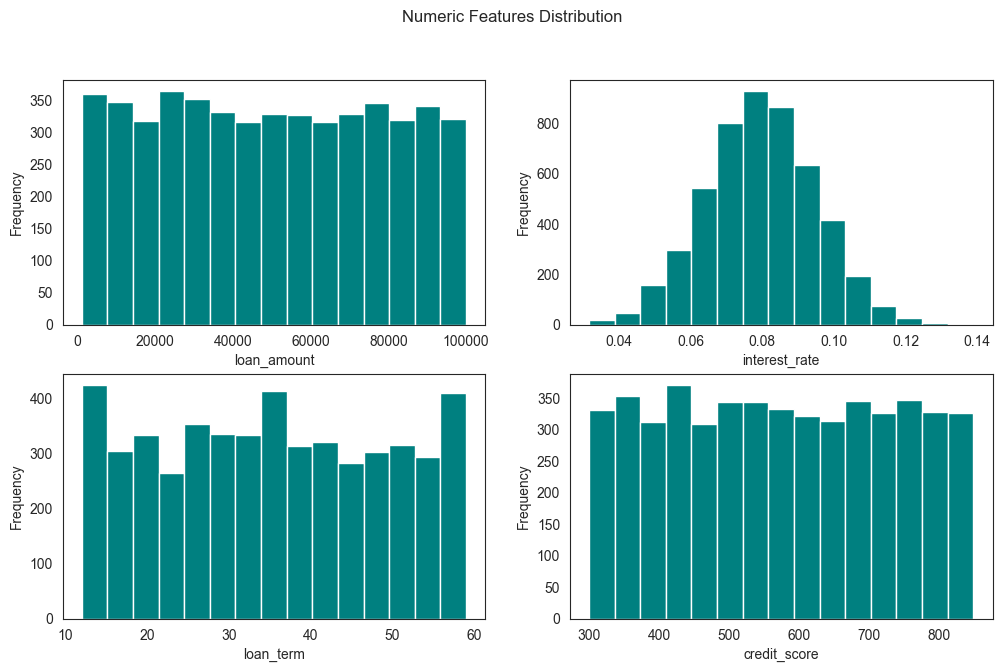

In [9]:
# Let's plot the histogram of the numeric data (loan_amount, interest_rate, loan_term, credit_score)
sns.set_style('white')
fig, axs = plt.subplots(figsize=(12,7),
                        nrows=2,
                        ncols=2)

# Create a list of the numeric features
num_features = ['loan_amount', 'interest_rate', 'loan_term', 'credit_score']

# Plot the histogram by using for loop
for num_features, ax in zip(num_features, axs.ravel()):
    ax.hist(df[num_features], color='teal', bins=15)
    ax.set_xlabel(num_features)
    ax.set_ylabel('Frequency')
    
# Set the title
plt.suptitle('Numeric Features Distribution')
plt.show()

### Visualize now other features

In [10]:
# Create a function that gets the true value of the target per feature
def get_target(feature, target):
    """
    This function extracts the count of the value of target per each value of the features.
    feature: Name of the feature variable
    target: Name of the target variable
    Returns three lists, feature_list, defaulter_list, & non_defaulter_list
    """
    # Create a list of unique value of features
    feature_list = feature.unique()
    
    # Create a blank list for the value of the target
    defaulter_list = []
    non_defaulter_list = []
    
    # Run for loop to loop through every feature value that has 1 target value
    for val in feature_list:
        defaulter_val = feature[feature == val][target == 1].count()
        defaulter_list.append(defaulter_val)

    # Run for loop through every feature value that has 0 target value
    for non in feature_list:
        non_defaulter_val = feature[feature == non][target == 0].count()
        non_defaulter_list.append(non_defaulter_val)
        
    return feature_list, defaulter_list, non_defaulter_list

In [11]:
# Get all the categorical features using filter object and put them into a list
categorical_features = df.columns[df.dtypes == 'O'].tolist()

# Remove 'customer_id' and 'loan_id' from the list
categorical_features = [feature for feature in categorical_features if feature not in ['customer_id', 'loan_id']]

# Remove the underscore '_' and replace with space, then capitalize first letter
proper_categorical_features = [feature.replace('_', ' ').title() for feature in categorical_features]

# Create a dictionary using proper_categorical_features as key and categorical_features as value
categorical_features_dict = {proper: original for proper, original in zip(proper_categorical_features, categorical_features)}
categorical_features_dict

{'Loan Type': 'loan_type',
 'Employment Type': 'employment_type',
 'Income Level': 'income_level',
 'Gender': 'gender',
 'Marital Status': 'marital_status',
 'Education Level': 'education_level'}

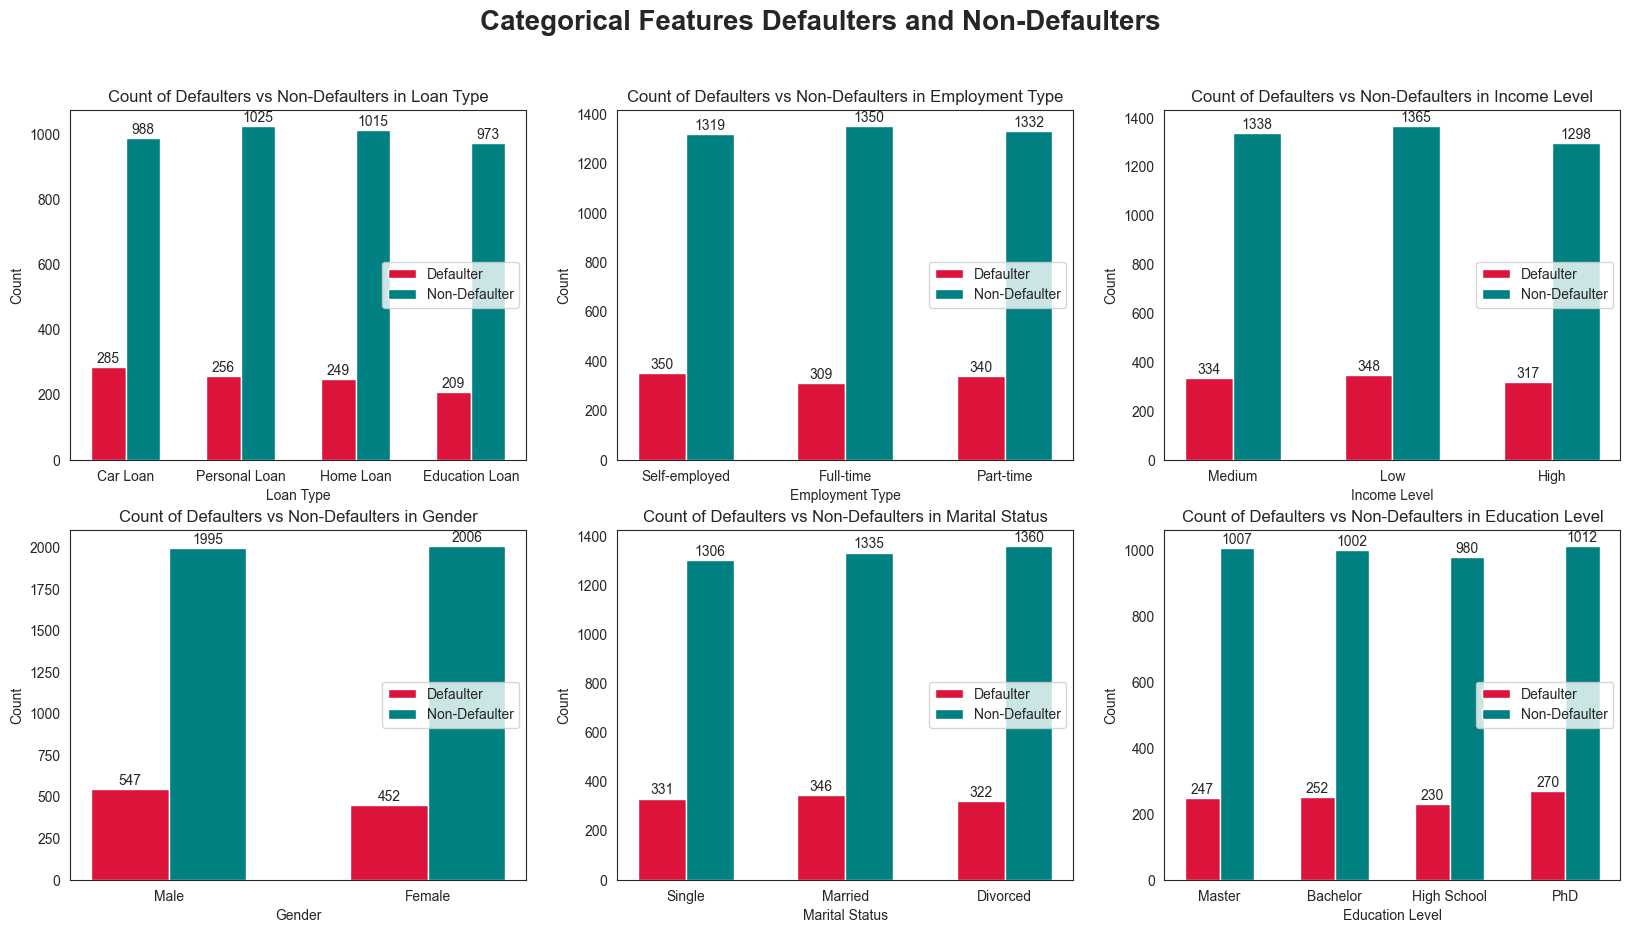

In [12]:
# Using the categorical feature dictionary create a bar plot for all the object list showing the value of 0 and 1 per each value in feature
fig, axs = plt.subplots(figsize=(20,10),
                       nrows=2,
                       ncols=3)

# Loop through each value on the dictionary to get details about the plot and plot it
for cat, ax in zip(categorical_features_dict.items(), axs.ravel()):
    feature_name, feature_column = cat
    # Use our function `get_target()` to get 3 lists, feature_list, defaulter_list, non_defaulter_list
    feature_list, defaulter_list, non_defaulter_list = get_target(feature=df[feature_column], target=df['default_status'])
    # Create x
    x = np.arange(len(feature_list))
    # Set the width
    width = 0.30
    
    # Create two bars for target values
    bar1 = ax.bar(x - width/2, defaulter_list, width, color='crimson', label='Defaulter')
    bar2 = ax.bar(x + width/2, non_defaulter_list, width, color='teal', label='Non-Defaulter')
    
    # Annotate bars
    for bar in bar1 + bar2:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0,1),
                    textcoords='offset points',
                    ha='center',
                    va='bottom')
    
    # Set more information about the graph
    ax.set_xlabel(feature_name)
    ax.set_ylabel('Count')
    ax.set_title(f'Count of Defaulters vs Non-Defaulters in {feature_name}')
    ax.set_xticks(x, feature_list)
    ax.legend(loc=5)
plt.suptitle('Categorical Features Defaulters and Non-Defaulters', fontweight='bold', fontsize=20)
plt.show()

### Now we visualize the dates columns base on target values by percentage.

Before we can visualize dates, we need to process it first. I will create a function that will separate dates into year and month column.

In [13]:
# Create a function that returns year and month for all the date column
def process_date(df):
    """
    This function filters all the date column datatypes in the whole dataset and create a year and month column for each of the date columns.
    """
    # First filter all the date columns and put it into a list
    df_col = df.columns.tolist()
    date_col = []
    for col in df_col:
        if df[col].dtype == '<M8[ns]':
            date_col.append(col)
    
    # Create year column for each date column
    for date in date_col:
        df[date + '_year'] = df[date].dt.year
        
    # Create month column for each date column
    for month in date_col:
        df[month + '_month'] = df[month].dt.month
    
    # Drop the original dates column
    df.drop(date_col, axis = 1, inplace=True)
    
    return df

In [14]:
# Make a copy of dataset for date visualization
df_dates = df.copy()

In [15]:
# Use the function to make year and month columns and drop the original date columns
process_date(df_dates)

,loan_type,loan_amount,interest_rate,loan_term,employment_type,income_level,credit_score,gender,marital_status,education_level,default_status,application_date_year,approval_date_year,disbursement_date_year,due_date_year,application_date_month,approval_date_month,disbursement_date_month,due_date_month
0,Car Loan,16795,0.051852,15,Self-employed,Medium,833,Male,Single,Master,0,2018,2018,2018,2018,4,4,4,8
1,Personal Loan,1860,0.089296,56,Full-time,Medium,776,Female,Married,Bachelor,0,2022,2022,2023,2023,12,12,1,4
2,Personal Loan,77820,0.070470,51,Full-time,Low,697,Male,Divorced,High School,0,2019,2019,2019,2020,11,11,11,2
3,Car Loan,55886,0.062155,30,Full-time,Low,795,Female,Married,PhD,0,2021,2021,2021,2022,8,9,9,2
4,Home Loan,7265,0.070635,48,Part-time,Low,519,Female,Married,High School,0,2020,2020,2020,2020,9,9,9,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Car Loan,37945,0.070087,57,Self-employed,High,511,Male,Married,PhD,0,2022,2022,2022,2022,1,2,2,6
4996,Personal Loan,48937,0.056405,50,Part-time,Medium,502,Male,Single,PhD,0,2018,2018,2018,2018,5,5,5,11
4997,Home Loan,7476,0.064212,58,Full-time,High,452,Female,Single,High School,1,2022,2022,2022,2023,10,10,11,4
4998,Car Loan,52756,0.094914,12,Self-employed,Medium,728,Male,Married,PhD,0,2018,2018,2018,2019,7,8,8,1


### Date visualization

1. Plot for month

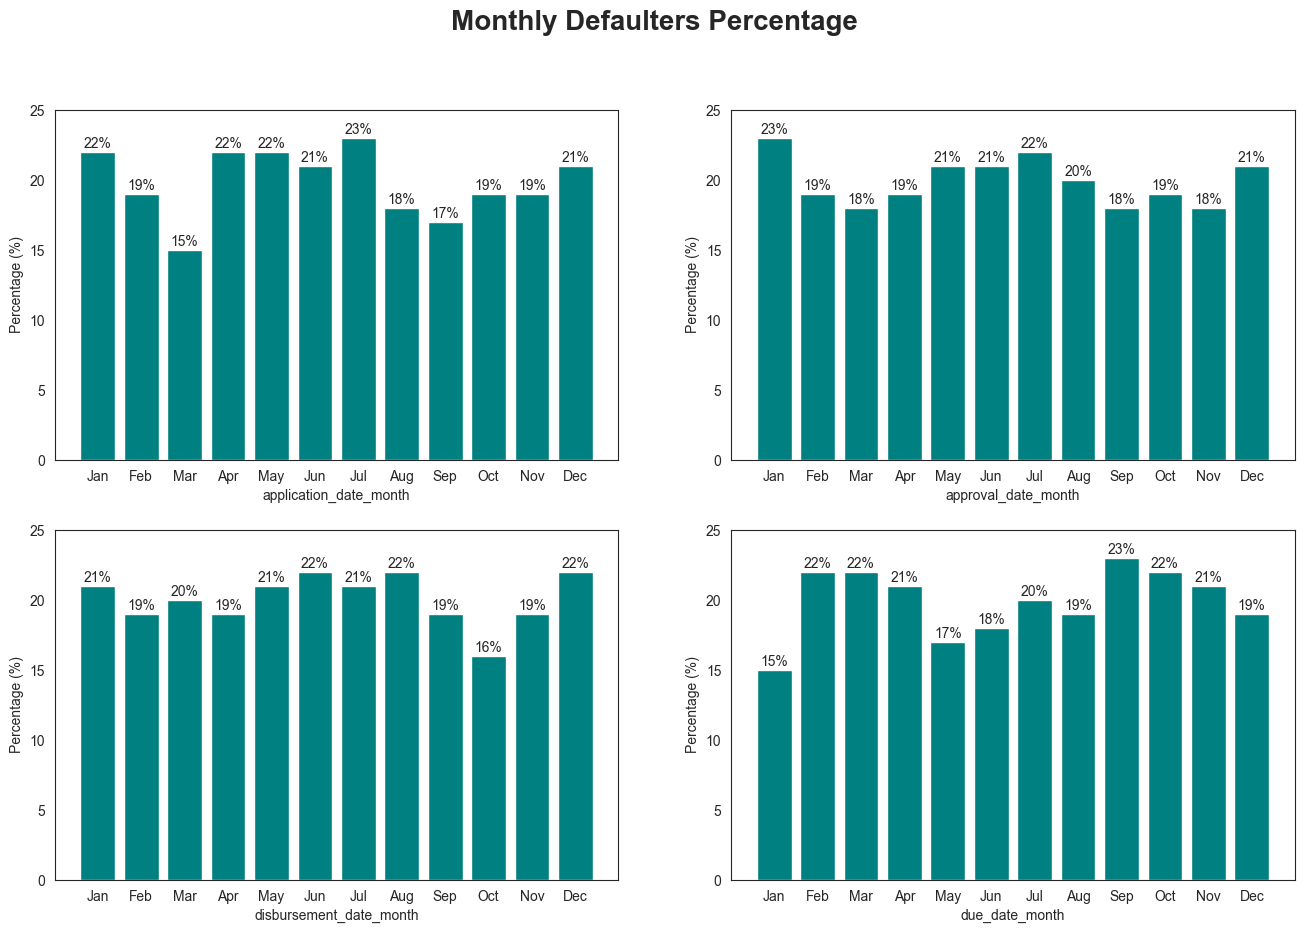

In [16]:
# Plot the month column with percentage of defaulter
fig, axs = plt.subplots(figsize=(16,10),
                       nrows=2,
                       ncols=2)

# List of month names for x-axis
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# List of month columns
month_col = ['application_date_month', 'approval_date_month', 'disbursement_date_month', 'due_date_month']

# Use for loop to plot
for col, ax in zip(month_col, axs.ravel()):
    # Get the percentage of per month first using for loop
    month_perc = []
    for i in range(1, 13):
        defaulter_count = df_dates[col][df_dates[col] == i][df_dates['default_status'] == 1].count()
        perc = defaulter_count / df_dates[col][df_dates[col] == i].count()
        month_perc.append(round(perc * 100))
    
    # Now plot the bar plot using percentage and month column names
    bars = ax.bar(month_names, month_perc, color='teal')
    
    # Annotate plot
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0,1),
                    textcoords='offset points',
                    ha='center',
                    va='bottom')
    
    # Set some information
    ax.set_xlabel(col)
    ax.set_ylabel('Percentage (%)')
    ax.set_ylim(0, 25)
    
fig.suptitle('Monthly Defaulters Percentage', fontweight='bold', fontsize=20)
plt.show()
    

2. Plot for the year

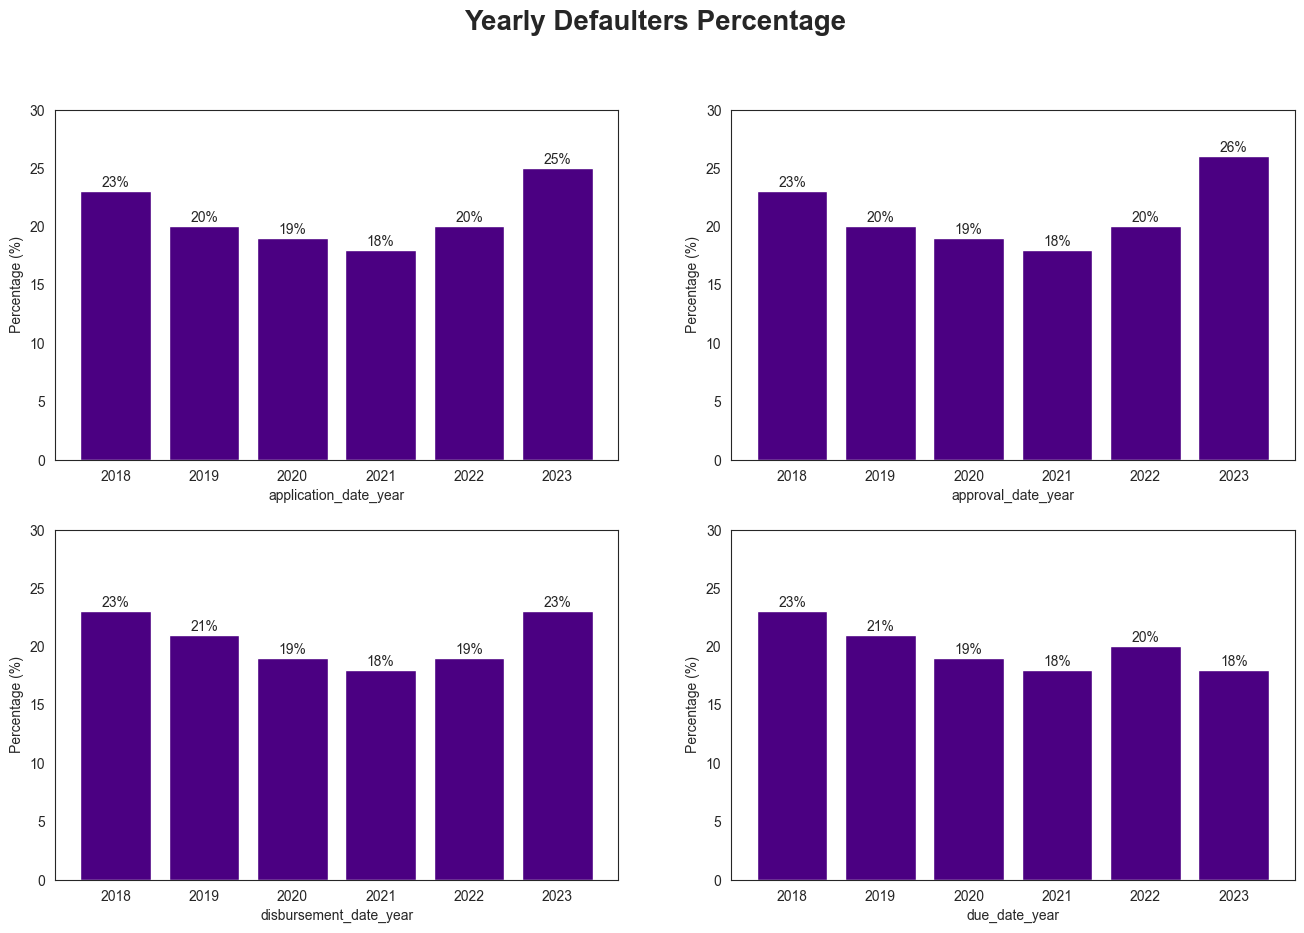

In [17]:
# Plot the month column with percentage of defaulter
fig, axs = plt.subplots(figsize=(16,10),
                       nrows=2,
                       ncols=2)

# List of year columns
year_col = ['application_date_year', 'approval_date_year', 'disbursement_date_year', 'due_date_year']

# Use for loop to plot
for col, ax in zip(year_col, axs.ravel()):
    # Get the value of years per columns and turn it into a list
    year = sorted(df_dates[col]
                  .unique()
                  .tolist())
    
    # Get the percentage of per year first using for loop
    year_perc = []
    for i in year:
        defaulter_count = df_dates[col][df_dates[col] == i][df_dates['default_status'] == 1].count()
        perc = defaulter_count / df_dates[col][df_dates[col] == i].count()
        year_perc.append(round(perc * 100))
    
    # Now plot the bar plot using percentage and month column names
    bars = ax.bar(year, year_perc, color='indigo')
    
    # Annotate plot
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0,1),
                    textcoords='offset points',
                    ha='center',
                    va='bottom')
        
    # Set some information
    ax.set_xlabel(col)
    ax.set_ylabel('Percentage (%)')
    ax.set_ylim(0, 30)
    
fig.suptitle('Yearly Defaulters Percentage', fontweight='bold', fontsize=20)
plt.show()

## Step 5. Feature Engineering

Base on EDA, we can perform some necessary feature engineering.

We combine some features to create more insightful features.

In [18]:
df.head()

,loan_type,loan_amount,interest_rate,loan_term,employment_type,income_level,credit_score,gender,marital_status,education_level,application_date,approval_date,disbursement_date,due_date,default_status
0,Car Loan,16795,0.051852,15,Self-employed,Medium,833,Male,Single,Master,2018-04-05,2018-04-23,2018-04-24,2018-08-14,0
1,Personal Loan,1860,0.089296,56,Full-time,Medium,776,Female,Married,Bachelor,2022-12-30,2022-12-31,2023-01-12,2023-04-05,0
2,Personal Loan,77820,0.070470,51,Full-time,Low,697,Male,Divorced,High School,2019-11-15,2019-11-18,2019-11-27,2020-02-24,0
3,Car Loan,55886,0.062155,30,Full-time,Low,795,Female,Married,PhD,2021-08-25,2021-09-08,2021-09-11,2022-02-25,0
4,Home Loan,7265,0.070635,48,Part-time,Low,519,Female,Married,High School,2020-09-02,2020-09-07,2020-09-11,2020-12-29,0


Let's copy again the dataset.

In [19]:
df_feat = df.copy()

I will create a feature that determines the total amount to be paid by the client. Loan amount is the loan that the client will get while the amount to be paid will be loan amount * (1 + interest rate).

In [20]:
# Create new column and perform formula
df_feat['total_amount'] = df_feat['loan_amount'] * (df_feat['interest_rate'] + 1)
df_feat.head(3)

,loan_type,loan_amount,interest_rate,loan_term,employment_type,income_level,credit_score,gender,marital_status,education_level,application_date,approval_date,disbursement_date,due_date,default_status,total_amount
0,Car Loan,16795,0.051852,15,Self-employed,Medium,833,Male,Single,Master,2018-04-05,2018-04-23,2018-04-24,2018-08-14,0,17665.849453
1,Personal Loan,1860,0.089296,56,Full-time,Medium,776,Female,Married,Bachelor,2022-12-30,2022-12-31,2023-01-12,2023-04-05,0,2026.089950
2,Personal Loan,77820,0.070470,51,Full-time,Low,697,Male,Divorced,High School,2019-11-15,2019-11-18,2019-11-27,2020-02-24,0,83303.941470


Create new feature that will determine the monthly payment

In [21]:
# Create a new column for monthly payment
df_feat['monthly_payment'] = df_feat['total_amount'] / df_feat['loan_term']
df_feat.head(3)

,loan_type,loan_amount,interest_rate,loan_term,employment_type,income_level,credit_score,gender,marital_status,education_level,application_date,approval_date,disbursement_date,due_date,default_status,total_amount,monthly_payment
0,Car Loan,16795,0.051852,15,Self-employed,Medium,833,Male,Single,Master,2018-04-05,2018-04-23,2018-04-24,2018-08-14,0,17665.849453,1177.723297
1,Personal Loan,1860,0.089296,56,Full-time,Medium,776,Female,Married,Bachelor,2022-12-30,2022-12-31,2023-01-12,2023-04-05,0,2026.089950,36.180178
2,Personal Loan,77820,0.070470,51,Full-time,Low,697,Male,Divorced,High School,2019-11-15,2019-11-18,2019-11-27,2020-02-24,0,83303.941470,1633.410617


I will create two new feature that will determine how long it took from loan application to loan disbursement, and from loan disbursement to due date

In [22]:
# Create column 'days_application_to_disbursement'
df_feat['days_application_to_disbursement'] = (df_feat['disbursement_date'] - df_feat['application_date']).dt.days

# Create column 'days_disbursement_to_due
df_feat['days_disbursement_to_due'] = (df_feat['due_date'] - df_feat['disbursement_date']).dt.days

# Drop the dates column
df_feat.drop(['disbursement_date', 'application_date', 'approval_date', 'due_date'], axis=1, inplace=True)

df_feat.head(3)

,loan_type,loan_amount,interest_rate,loan_term,employment_type,income_level,credit_score,gender,marital_status,education_level,default_status,total_amount,monthly_payment,days_application_to_disbursement,days_disbursement_to_due
0,Car Loan,16795,0.051852,15,Self-employed,Medium,833,Male,Single,Master,0,17665.849453,1177.723297,19,112
1,Personal Loan,1860,0.089296,56,Full-time,Medium,776,Female,Married,Bachelor,0,2026.089950,36.180178,13,83
2,Personal Loan,77820,0.070470,51,Full-time,Low,697,Male,Divorced,High School,0,83303.941470,1633.410617,12,89


Let's investigate the new features if they result to 0, all 0 will be converted into 1 assuming it still took 1 day to process

In [23]:
df_feat['days_application_to_disbursement'].min(), df_feat['days_disbursement_to_due'].min()

(0, 30)

In [24]:
# Replace 0, by 1
df_feat['days_application_to_disbursement'] = df_feat['days_application_to_disbursement'].replace(0, 1)

In [25]:
# Check again
df_feat['days_application_to_disbursement'].min()

1

Drop loan_amount and loan_term columns since we already use this to create new feature

In [26]:
df_feat.drop(['loan_amount', 'loan_term'], axis=1, inplace=True)
df_feat.head(3)

,loan_type,interest_rate,employment_type,income_level,credit_score,gender,marital_status,education_level,default_status,total_amount,monthly_payment,days_application_to_disbursement,days_disbursement_to_due
0,Car Loan,0.051852,Self-employed,Medium,833,Male,Single,Master,0,17665.849453,1177.723297,19,112
1,Personal Loan,0.089296,Full-time,Medium,776,Female,Married,Bachelor,0,2026.089950,36.180178,13,83
2,Personal Loan,0.070470,Full-time,Low,697,Male,Divorced,High School,0,83303.941470,1633.410617,12,89


### Export the cleaned data

In [27]:
df_feat.to_csv('data/clean_loan.csv', index=False)

## Step 6. Data Preprocessing

Now we need to perform necessary procedures to preprocess our data such as:
1. Creating X & y
2. Encoding Categorical Features
3. Splitting data
4. Feature Scaling
5. Etc.

### Create X & y

In [28]:
X = df_feat.drop(['default_status'], axis=1)
y = df_feat['default_status']

In [29]:
X.head(3)

,loan_type,interest_rate,employment_type,income_level,credit_score,gender,marital_status,education_level,total_amount,monthly_payment,days_application_to_disbursement,days_disbursement_to_due
0,Car Loan,0.051852,Self-employed,Medium,833,Male,Single,Master,17665.849453,1177.723297,19,112
1,Personal Loan,0.089296,Full-time,Medium,776,Female,Married,Bachelor,2026.089950,36.180178,13,83
2,Personal Loan,0.070470,Full-time,Low,697,Male,Divorced,High School,83303.941470,1633.410617,12,89


### Encode categorical features

Encode gender first and use drop first since it's only binary

In [30]:
# Use pandas get dummies
X = pd.get_dummies(X, 
                   columns=['gender'],
                   dtype=int,
                   drop_first=True)
X.head(3)

,loan_type,interest_rate,employment_type,income_level,credit_score,marital_status,education_level,total_amount,monthly_payment,days_application_to_disbursement,days_disbursement_to_due,gender_Male
0,Car Loan,0.051852,Self-employed,Medium,833,Single,Master,17665.849453,1177.723297,19,112,1
1,Personal Loan,0.089296,Full-time,Medium,776,Married,Bachelor,2026.089950,36.180178,13,83,0
2,Personal Loan,0.070470,Full-time,Low,697,Divorced,High School,83303.941470,1633.410617,12,89,1


Encode the rest of category

In [31]:
# Using list comprehension to get all the reamining object type from columns
obj_col = [col for col in X.columns if X[col].dtype == 'O']

# Using the object columns we pass it to pandas get dummies to get the one hot encode of the columns
X = pd.get_dummies(X,
                   columns=obj_col,
                   dtype=int)
X.head(3)

,interest_rate,credit_score,total_amount,monthly_payment,days_application_to_disbursement,days_disbursement_to_due,gender_Male,loan_type_Car Loan,loan_type_Education Loan,loan_type_Home Loan,...,income_level_High,income_level_Low,income_level_Medium,marital_status_Divorced,marital_status_Married,marital_status_Single,education_level_Bachelor,education_level_High School,education_level_Master,education_level_PhD
0,0.051852,833,17665.849453,1177.723297,19,112,1,1,0,0,...,0,0,1,0,0,1,0,0,1,0
1,0.089296,776,2026.089950,36.180178,13,83,0,0,0,0,...,0,0,1,0,1,0,1,0,0,0
2,0.070470,697,83303.941470,1633.410617,12,89,1,0,0,0,...,0,1,0,1,0,0,0,1,0,0


Check the distribution of the new features

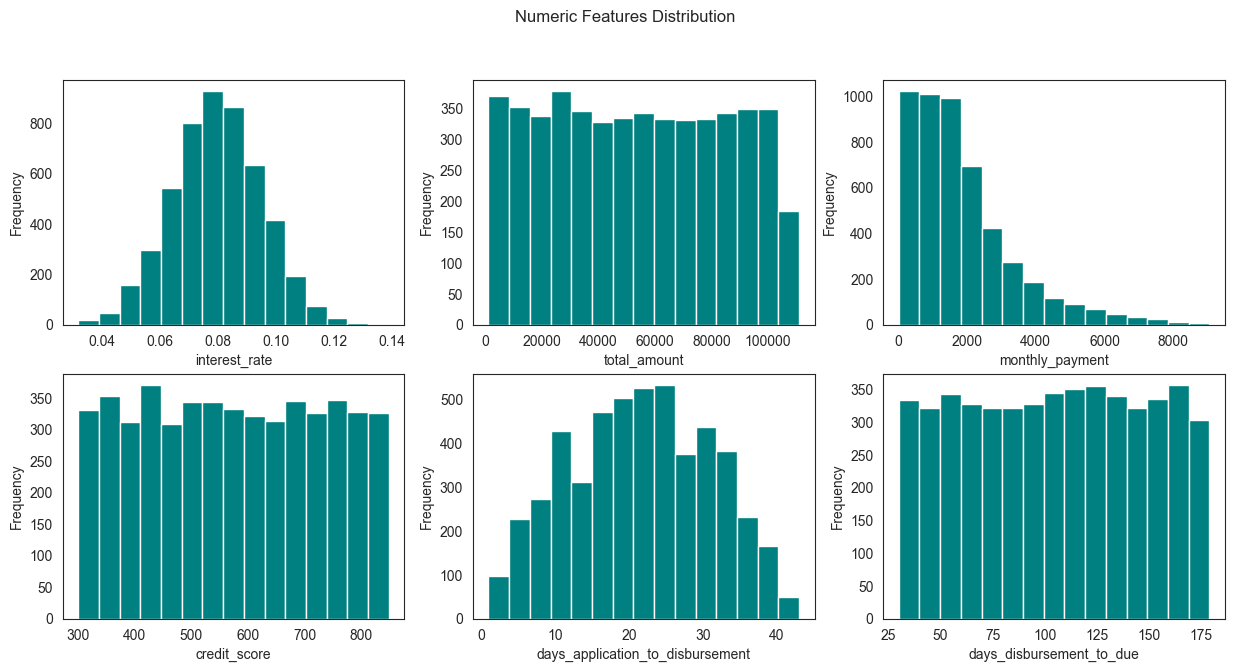

In [32]:
# Let's plot the histogram of the numeric data
sns.set_style('white')
fig, axs = plt.subplots(figsize=(15,7),
                        nrows=2,
                        ncols=3)

# Create a list of the numeric features
num_features = ['interest_rate', 'total_amount', 'monthly_payment', 'credit_score', 'days_application_to_disbursement', 'days_disbursement_to_due']

# Plot the histogram by using for loop
for num_features, ax in zip(num_features, axs.ravel()):
    ax.hist(X[num_features], color='teal', bins=15)
    ax.set_xlabel(num_features)
    ax.set_ylabel('Frequency')
    
# Set the title
plt.suptitle('Numeric Features Distribution')
plt.show()

### Splitting the data to train and test set

In [33]:
# Import train_test_split as tts
from sklearn.model_selection import train_test_split as tts

# Split the dataset
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.25, random_state=2)

# Check the shape of X_tain and X_test
X_train.shape, X_test.shape

((3750, 24), (1250, 24))

### Feature Scaling

We will be experimenting different types of scaling especially to 'total_amount', 'monthly_payment', 'credit_score', 'days_application_to_disbursement', and 'days_disbursement_to_due' since they show uniform distribution or left skewed distribution.

We will try to perform the following to convert them from uniform to gaussian distribution:
* Logarithmic Transformation
* Reciprocal Transformation
* Square root Transformation
* Exponential Transformation
* Boxcox Transformation

Let's create a function that will plot the feature to check if it's gaussian using one of these transformation.

In [34]:
# Create a function named plot_feat
def plot_feat(df, feature):
    fig, (ax1, ax2) = plt.subplots(figsize=(11,4),
                           ncols=2,
                           nrows=1)
    
    # Histogram plot
    ax1.hist(df[feature], bins=20)
    ax1.set_title(f'Histogram of {feature}.')
    
    # Plot of probability or QQ plot
    stat.probplot(df[feature], dist='norm', plot=ax2)
    ax2.set_title(f'QQ Plot of {feature}.')
    
    plt.show()
    

In [35]:
# Make a list of the features
dist_feat = [ 'total_amount', 'monthly_payment', 'credit_score', 'days_application_to_disbursement', 'days_disbursement_to_due']

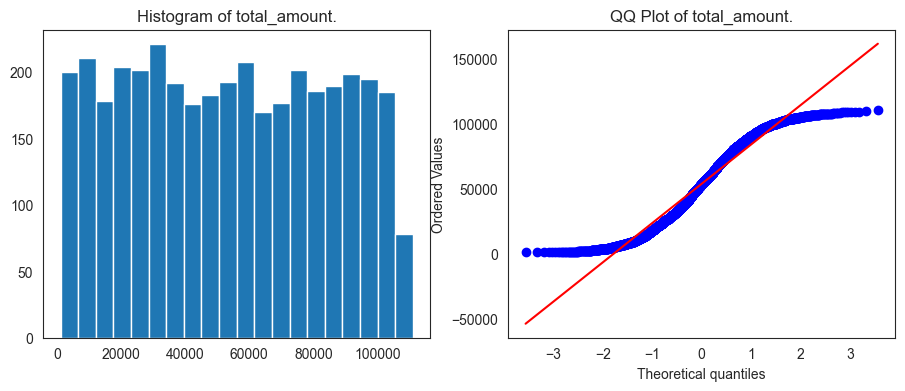

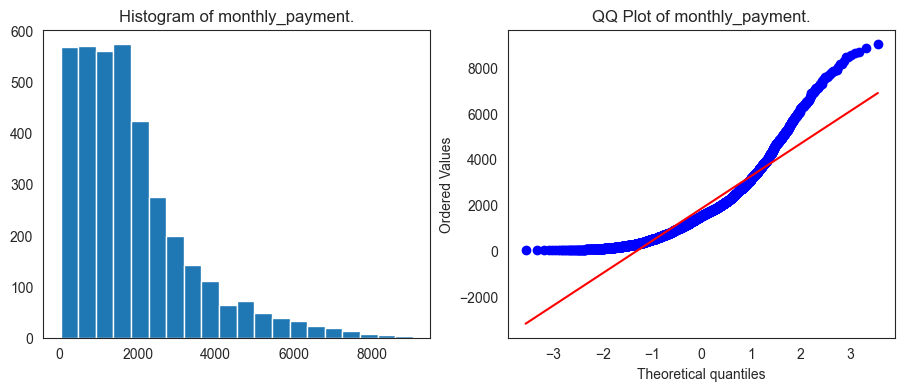

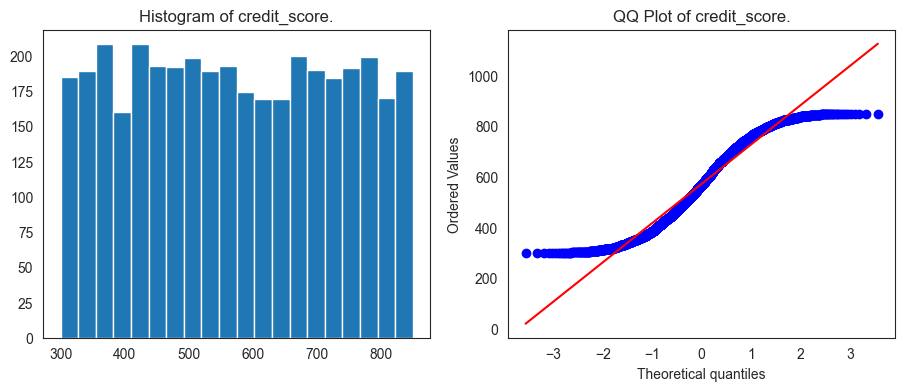

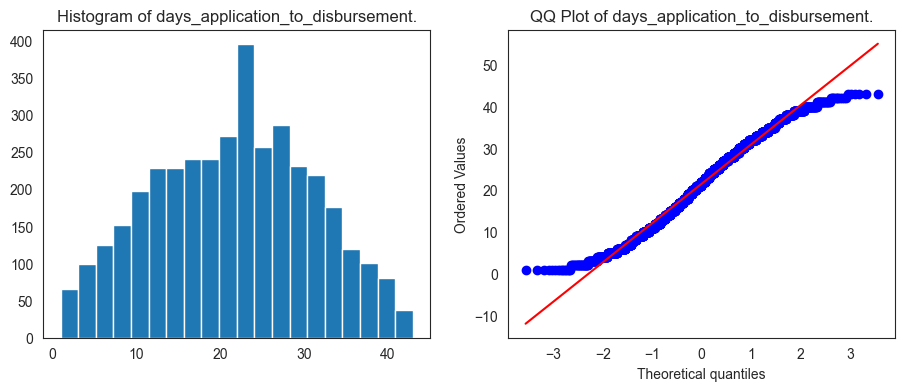

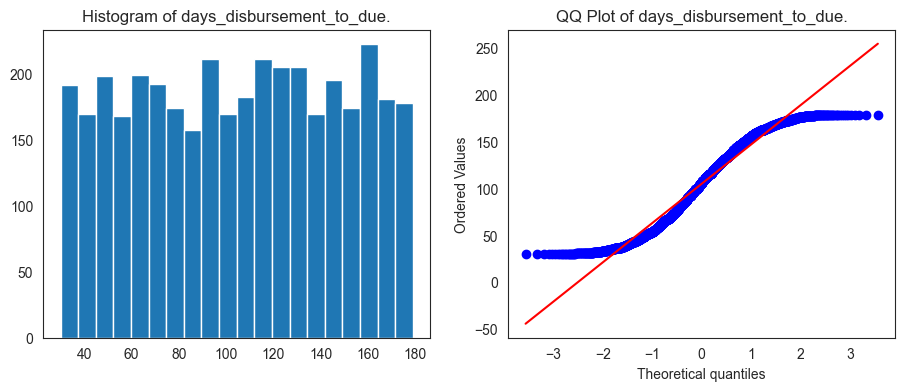

In [36]:
# Plot the initial QQ plot
for i in range(0, 5):
    plot_feat(X_train, dist_feat[i])

Make a copy of X_train for experimentation

In [37]:
X_train_exp = X_train.copy()

### Logarithmic Transformation

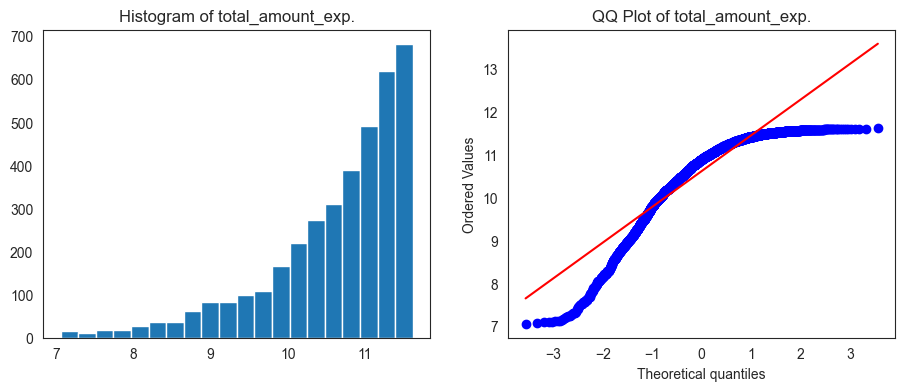

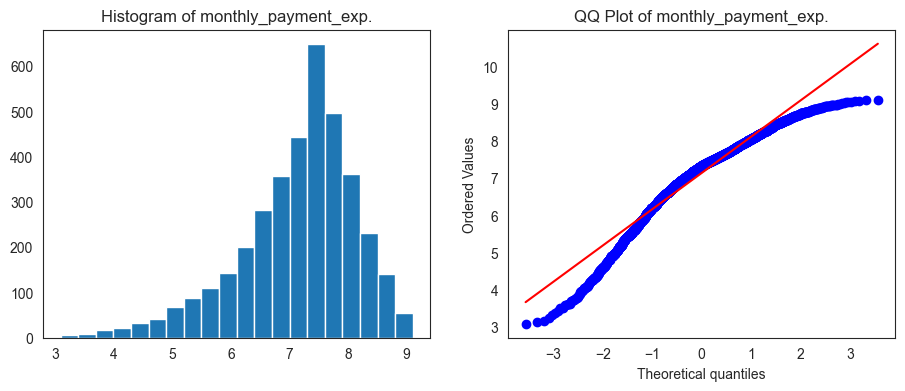

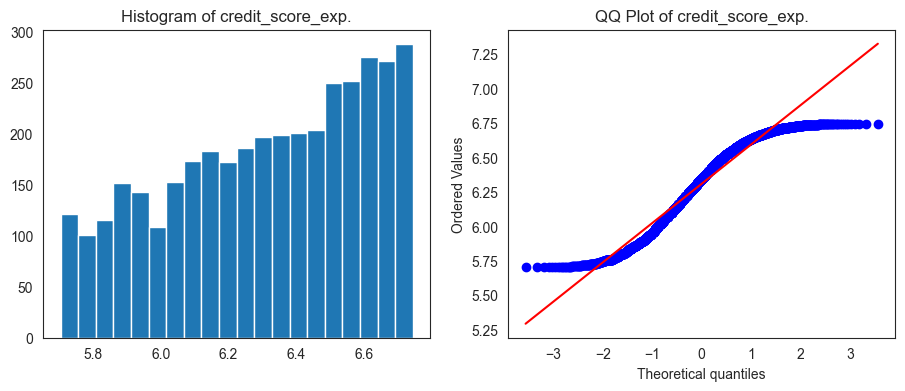

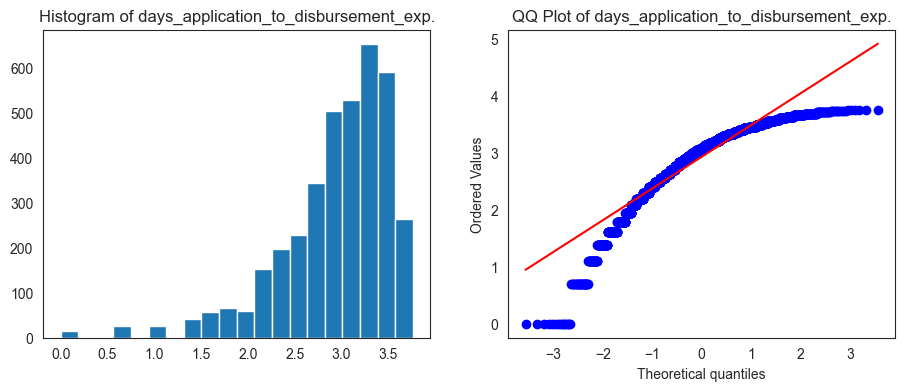

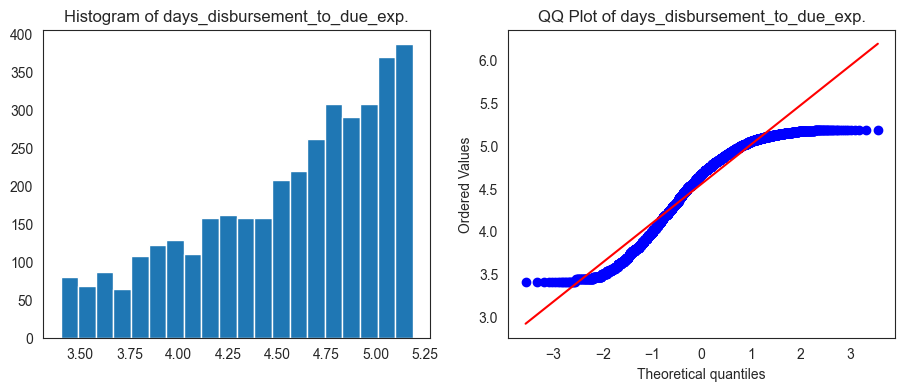

In [38]:
# Utilize for loop to loop through dist_feat list to scaled them
for i in range(0, 5):
    # Create a new column with '_exp' to indicate the experimental column then use np.log to scale
    X_train_exp[dist_feat[i] + '_exp'] = np.log(X_train_exp[dist_feat[i]])
    
    # Plot using the function
    plot_feat(X_train_exp, dist_feat[i] + '_exp')

### Reciprocal Transformation

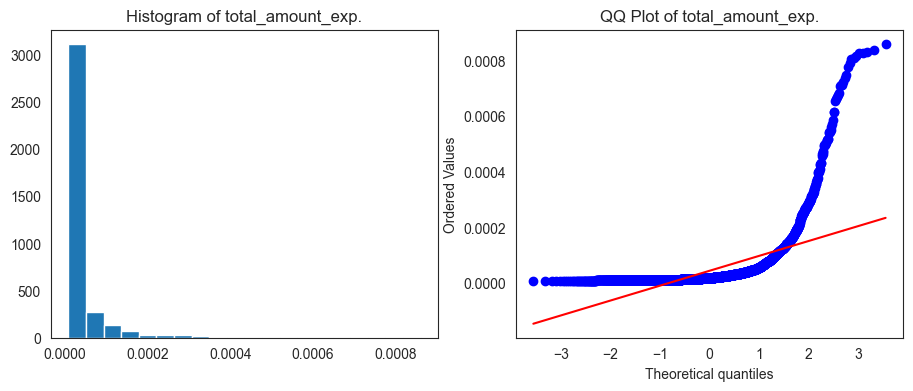

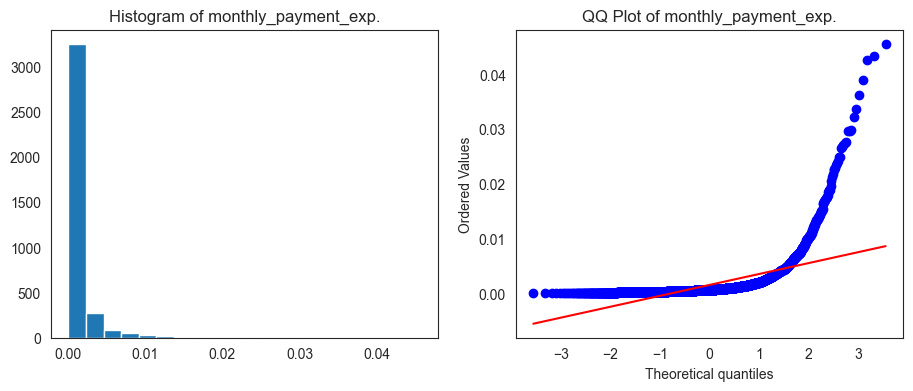

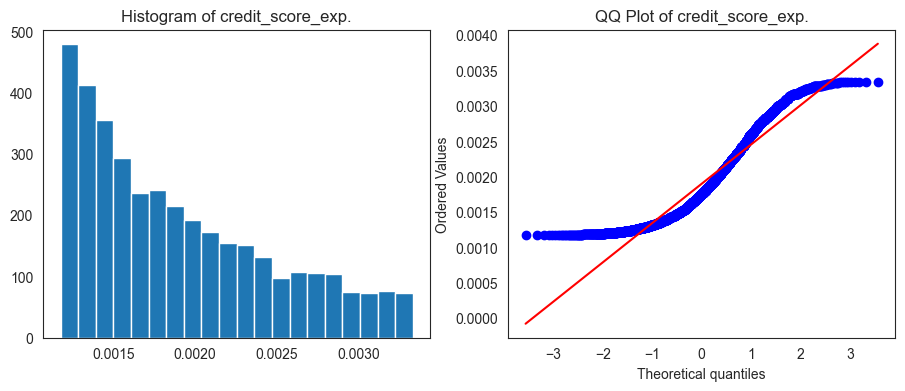

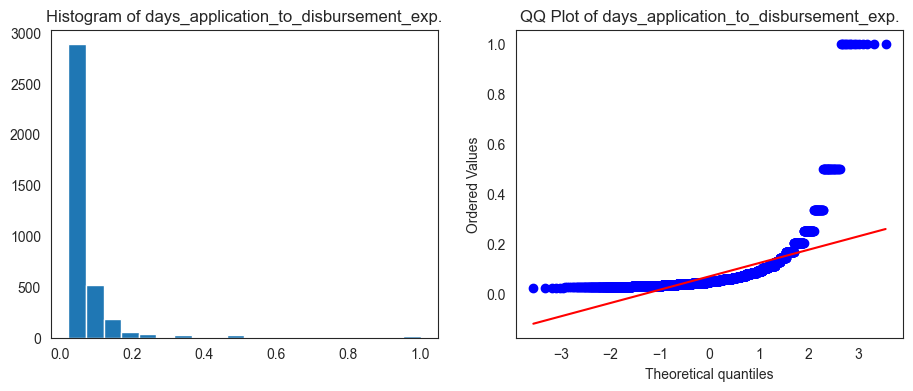

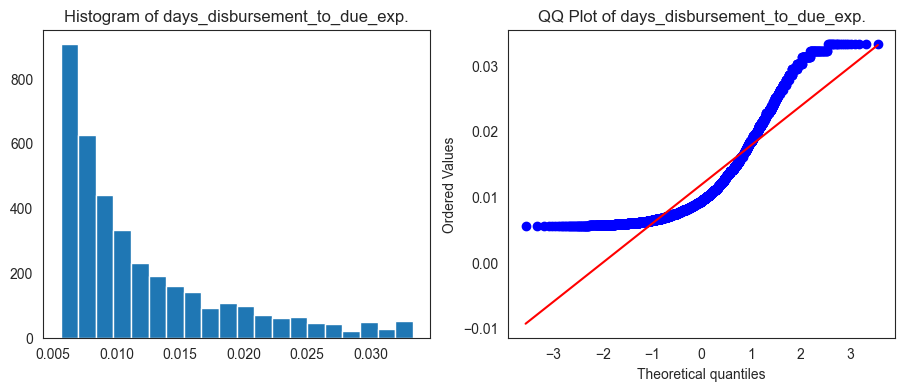

In [39]:
# Utilize for loop to loop through dist_feat list to scaled them
for i in range(0, 5):
    # Create a new column with '_exp' to indicate the experimental column then reciprocate
    X_train_exp[dist_feat[i] + '_exp'] = 1/X_train_exp[dist_feat[i]]
    
    # Plot using the function
    plot_feat(X_train_exp, dist_feat[i] + '_exp')

### Square Root Transformation

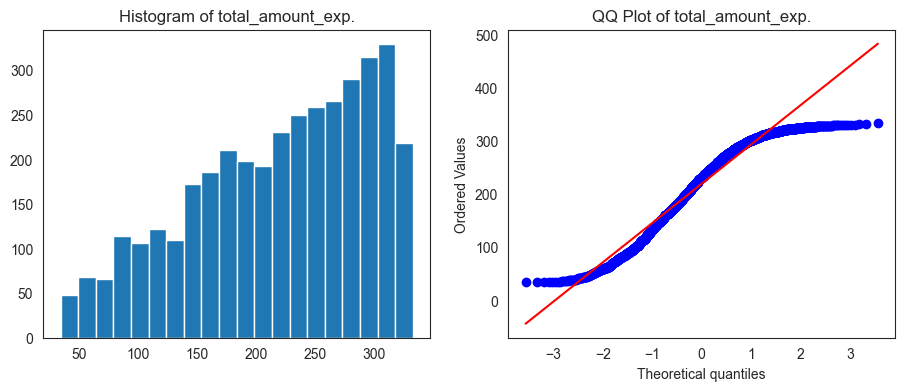

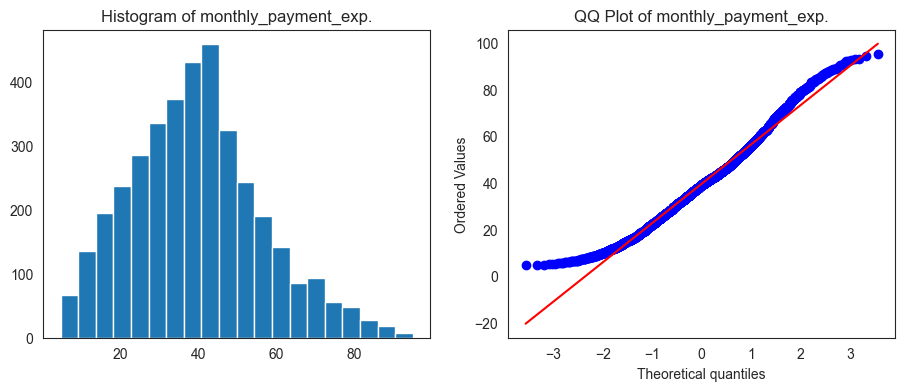

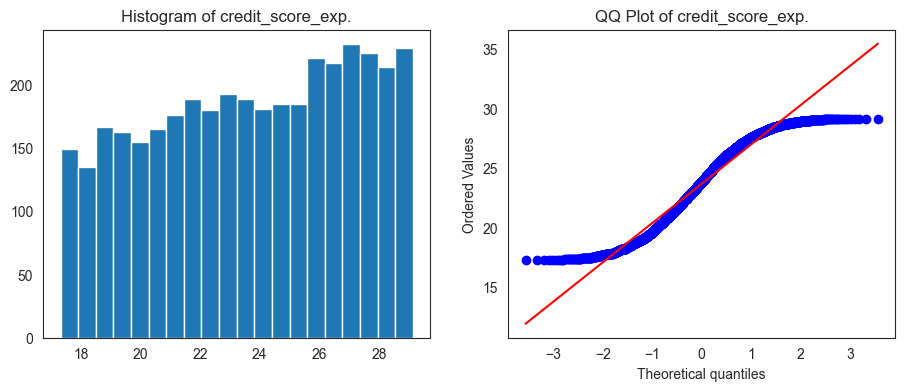

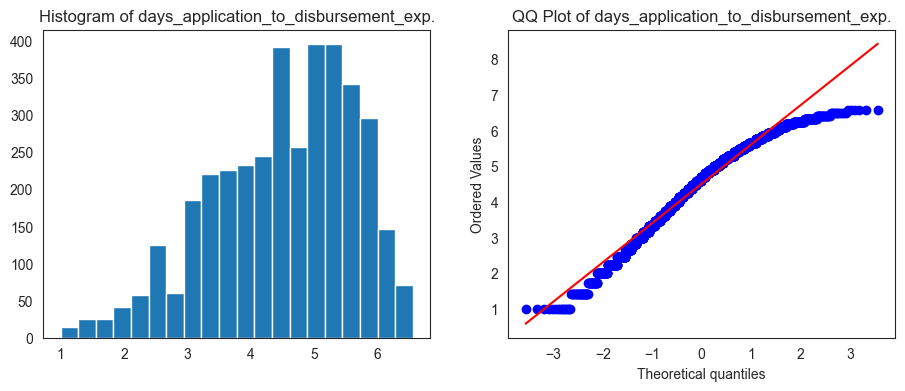

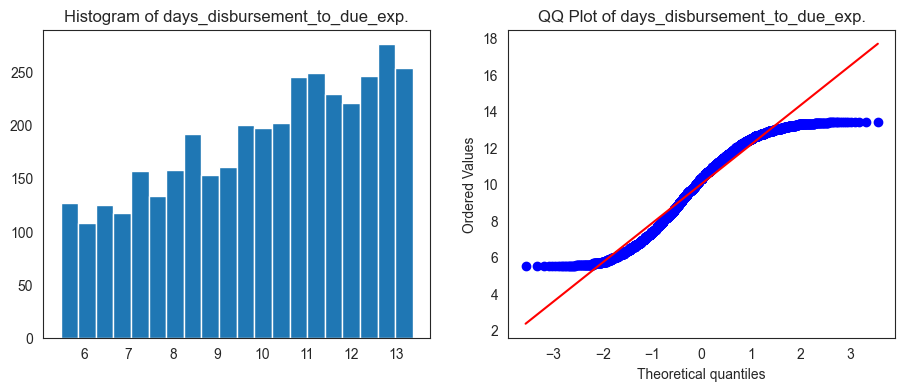

In [40]:
# Utilize for loop to loop through dist_feat list to scaled them
for i in range(0, 5):
    # Create a new column with '_exp' to indicate the experimental column then take the sqaure root
    X_train_exp[dist_feat[i] + '_exp'] = X_train_exp[dist_feat[i]]**(1/2)
    
    # Plot using the function
    plot_feat(X_train_exp, dist_feat[i] + '_exp')

### Exponential Transformation

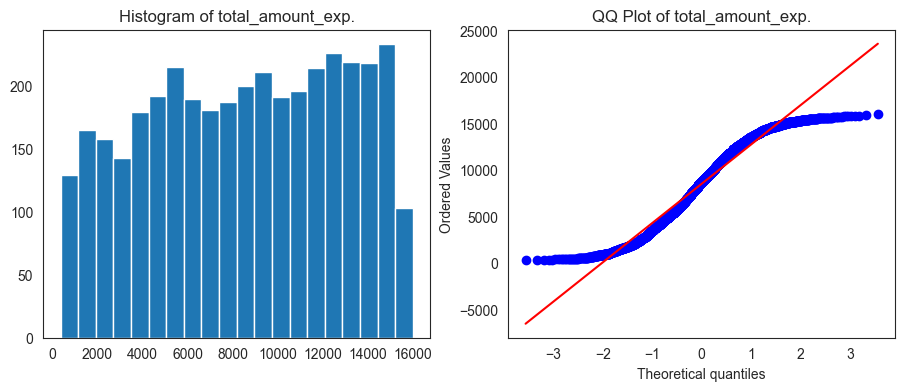

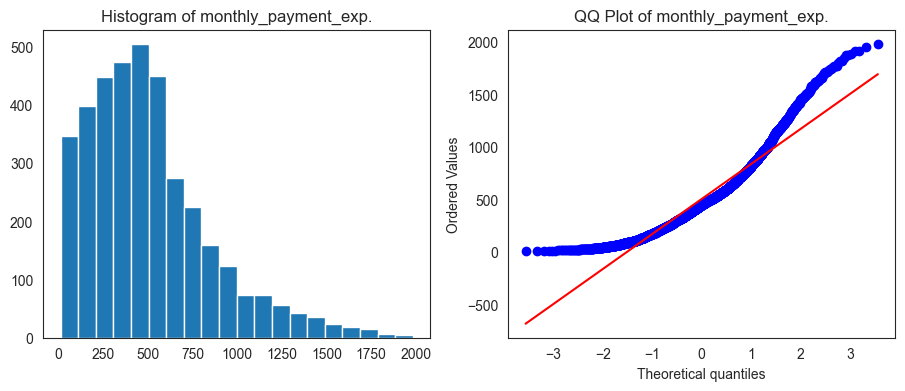

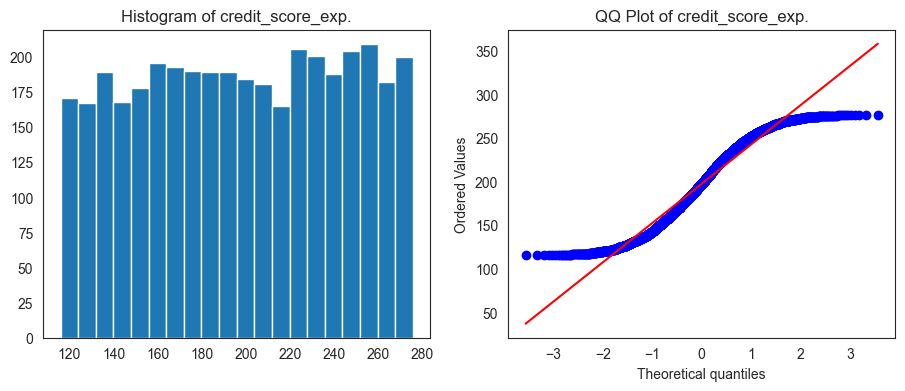

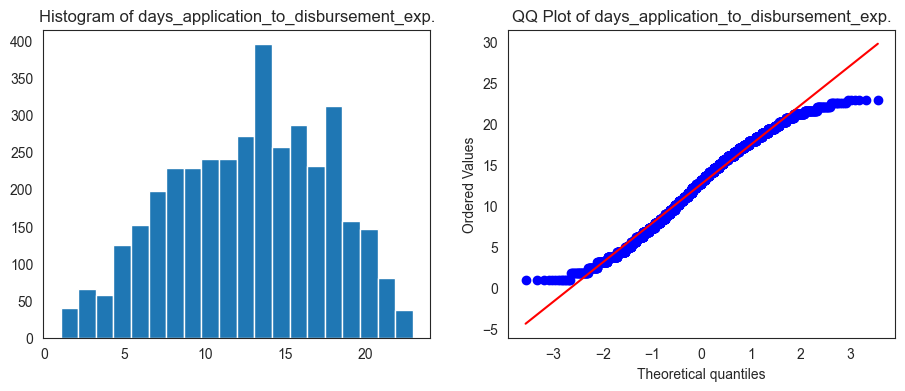

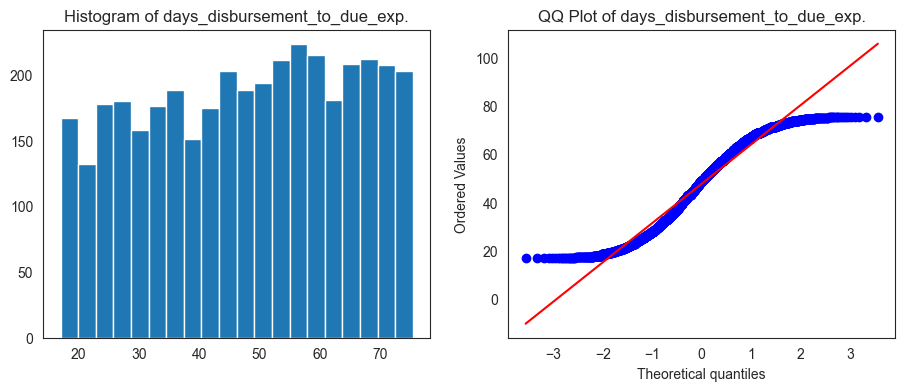

In [41]:
# Utilize for loop to loop through dist_feat list to scaled them
for i in range(0, 5):
    # Create a new column with '_exp' to indicate the experimental column then use exponent
    X_train_exp[dist_feat[i] + '_exp'] = X_train_exp[dist_feat[i]]**(1/1.2)
    
    # Plot using the function
    plot_feat(X_train_exp, dist_feat[i] + '_exp')

### Boxcox Transformation

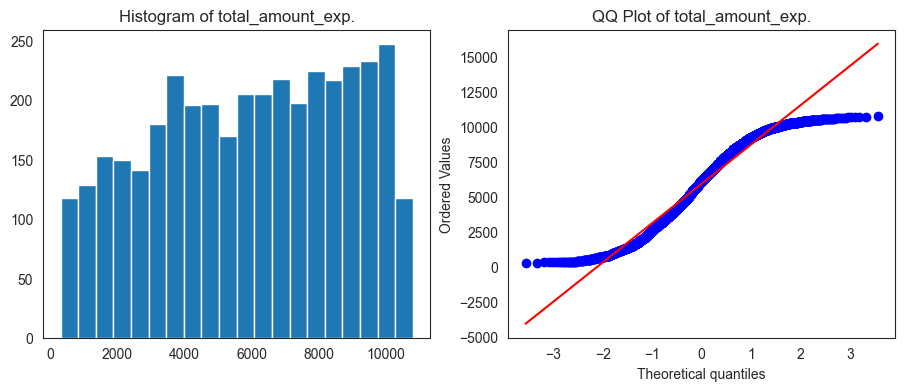

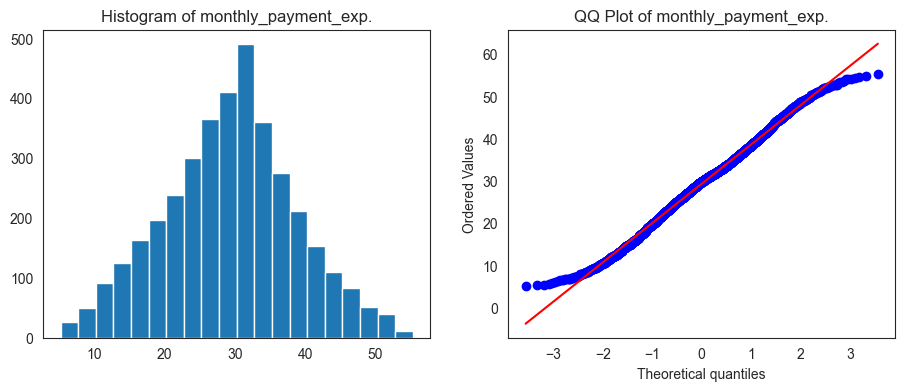

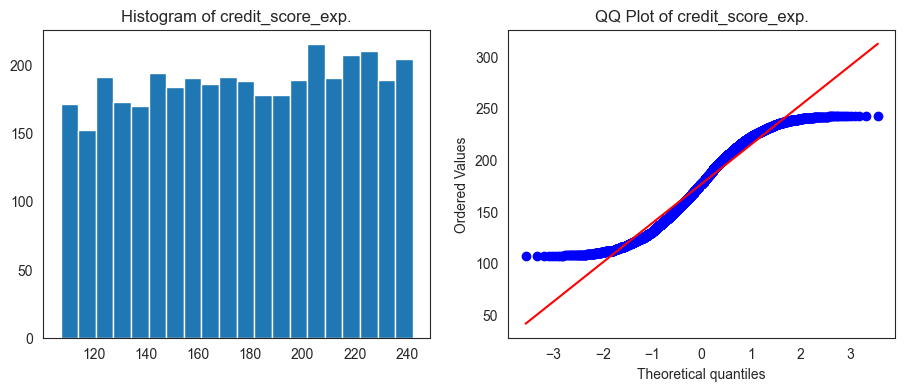

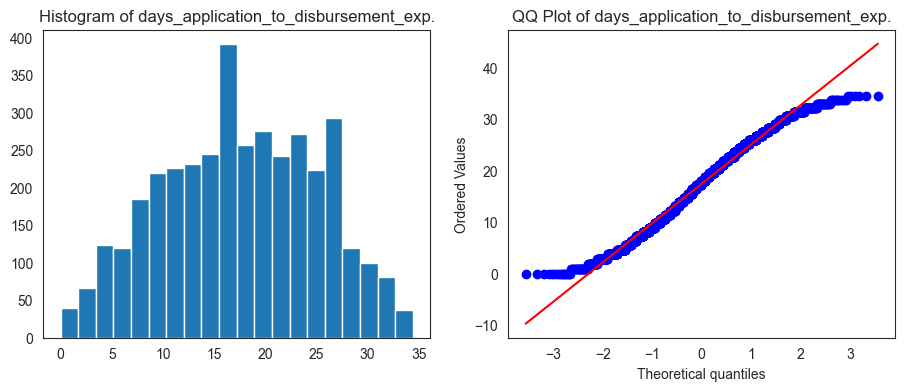

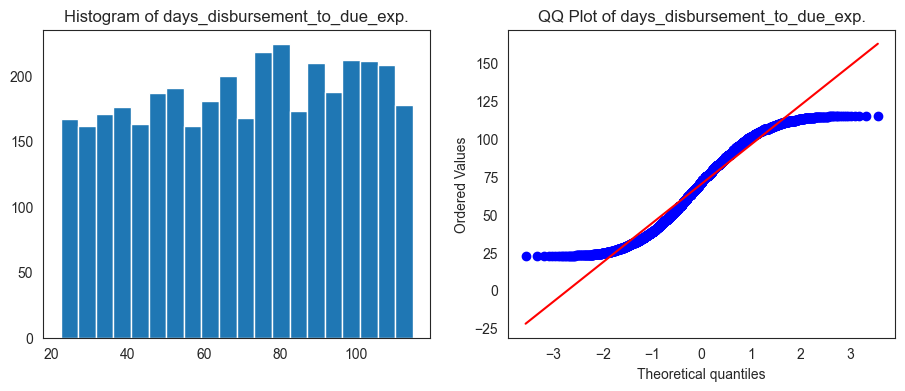

In [42]:
# Import normmax
from scipy.stats import boxcox_normmax
# Utilize for loop to loop through dist_feat list to scaled them
for i in range(0, 5):
    # Use the optimal lambda for boxcox
    optimal_lambda = boxcox_normmax(X_train_exp[dist_feat[i]])
    
    # Create a new column with '_exp' to indicate the experimental column then use exponent
    X_train_exp[dist_feat[i] + '_exp'] = stat.boxcox(X_train_exp[dist_feat[i]], optimal_lambda)
    
    # Plot using the function
    plot_feat(X_train_exp, dist_feat[i] + '_exp')

Based on the experimentation, the best transformation technique for each features differs.

1. 'total_amount': We can observed that the best transformation for this is the square root, although we didn't achieve a perfect gaussian, left skeweness will do.
2. 'monthly_payment': We can observed that the best transformation for this is the boxcox, it made it almost perfect gaussian.
3. 'credit_score': We can observed that the best transformation for this is the reciprocal, although this is also not perfect gaussian, we will take the right skewed one.
4. 'days_application_to_disbursement': We can observed that the initial distribution is already good, we will just apply the normal feature scaling.
5. 'days_disbursement_to_due': We will take the logarithmic transformation for this feature.

### Perform the best transformation method base on the experimentation on other features

In [43]:
# Square root transformation for 'total_amount'
X_train['total_amount'] = X_train['total_amount']**(1/2)
# Apply also to test set
X_test['total_amount'] = X_test['total_amount']**(1/2)

# Boxcox transformation for 'monthly_payment'
# Make two lambdas for train and test
lambda_train = boxcox_normmax(X_train['monthly_payment'])
lambda_test = boxcox_normmax(X_test['monthly_payment'])
# Transform train set using lambda train
X_train['monthly_payment'] = stat.boxcox(X_train['monthly_payment'], lambda_train)
# Transform test set using lambda test
X_test['monthly_payment'] = stat.boxcox(X_test['monthly_payment'], lambda_test)

# Reciprocal transformation for 'credit_score'
X_train['credit_score'] = 1/X_train['credit_score']
# Apply also to test set
X_test['credit_score'] = 1/X_test['credit_score']

# Logarithmic transformation for 'days_disbursement_to_due'
X_train['days_disbursement_to_due'] =  np.log(X_train['days_disbursement_to_due'])
# Apply also to test set
X_test['days_disbursement_to_due'] = np.log(X_test['days_disbursement_to_due'])

In [44]:
X_train.head(3)

,interest_rate,credit_score,total_amount,monthly_payment,days_application_to_disbursement,days_disbursement_to_due,gender_Male,loan_type_Car Loan,loan_type_Education Loan,loan_type_Home Loan,...,income_level_High,income_level_Low,income_level_Medium,marital_status_Divorced,marital_status_Married,marital_status_Single,education_level_Bachelor,education_level_High School,education_level_Master,education_level_PhD
4715,0.103088,0.001302,265.610793,31.380386,22,3.433987,0,0,0,1,...,1,0,0,0,0,1,0,0,0,1
3576,0.077645,0.001701,59.471251,11.171924,31,4.290459,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0
4996,0.056405,0.001992,227.370401,25.930934,15,5.176150,1,0,0,0,...,0,0,1,0,0,1,0,0,0,1


### Standardize all the numeric features

In [45]:
# Make a list of the numeric features
feat_col = ['interest_rate', 'total_amount', 'monthly_payment', 'credit_score', 'days_application_to_disbursement', 'days_disbursement_to_due']

# Import StandardScaler
from sklearn.preprocessing import StandardScaler

# Instantiate StandardScaler
sc = StandardScaler()

# Feature scale the train and test set
X_train[feat_col] = sc.fit_transform(X_train[feat_col])
X_test[feat_col] = sc.transform(X_test[feat_col])

### One last look at the final distribution

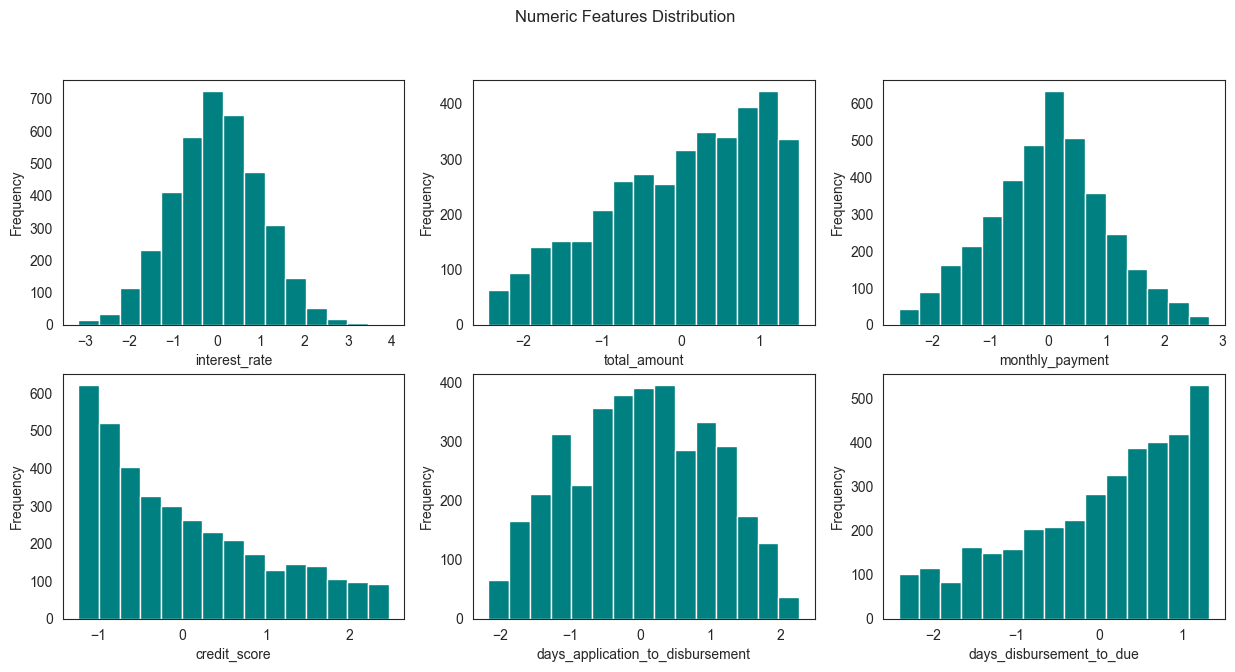

In [46]:
# Let's plot the histogram of the numeric data
sns.set_style('white')
fig, axs = plt.subplots(figsize=(15,7),
                        nrows=2,
                        ncols=3)

# Create a list of the numeric features
num_features = ['interest_rate', 'total_amount', 'monthly_payment', 'credit_score', 'days_application_to_disbursement', 'days_disbursement_to_due']

# Plot the histogram by using for loop
for num_features, ax in zip(num_features, axs.ravel()):
    ax.hist(X_train[num_features], color='teal', bins=15)
    ax.set_xlabel(num_features)
    ax.set_ylabel('Frequency')
    
# Set the title
plt.suptitle('Numeric Features Distribution')
plt.show()

In [47]:
X_train.head(3)

,interest_rate,credit_score,total_amount,monthly_payment,days_application_to_disbursement,days_disbursement_to_due,gender_Male,loan_type_Car Loan,loan_type_Education Loan,loan_type_Home Loan,...,income_level_High,income_level_Low,income_level_Medium,marital_status_Divorced,marital_status_Married,marital_status_Single,education_level_Bachelor,education_level_High School,education_level_Master,education_level_PhD
4715,1.558962,-1.031996,0.610087,0.217174,0.047607,-2.346277,0,0,0,1,...,1,0,0,0,0,1,0,0,0,1
3576,-0.125660,-0.345322,-2.109092,-1.954630,0.997786,-0.551878,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0
4996,-1.531941,0.156598,0.105660,-0.368479,-0.691420,1.303737,1,0,0,0,...,0,0,1,0,0,1,0,0,0,1


## Step 7. Modelling

Now that we have preprocess our data. We can now experiment on different models.

We select right estimators base on scikit-learn meachine learning model map: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

1. Perform baseline model (no hyperparameter tuning) using the following models:
    * SVM with linear kernel
    * Naive Bayes
    * KNearestNeighbors
    * RandomForestClassifiers
    * XGBoost
2. Score each model.
3. Perform necessary procedures to handle imbalance class.
4. Perform the models again and use hyperparameter tuning and score again.

I will create a very simple function that will score the model and put it into a dictionary. Base on the objective, the score parameter needed is accuracy.

In [48]:
# Import library for accuracy score
from sklearn.metrics import accuracy_score

# Create a fucntion that will take 3 inputs, y_true value, y_predicted, and the dictionary name
def evaluate_model(y_true, y_predictions, model_name, score_dictionary):
    model_score = accuracy_score(y_true, y_predictions)
    score_dictionary[model_name] = model_score * 100
 
    return score_dictionary

In [49]:
# Create a dictionary for the baseline models
baseline_scores = {}

### SVM with linear kernel

In [76]:
# Import SVC
from sklearn.svm import SVC

# Instatiate SVC
lin_svc = SVC(kernel='linear', random_state=42)

# Fit linear SVC
lin_svc.fit(X_train, y_train)

# Predict using linear svc
y_preds = lin_svc.predict(X_test)

# Evaluate
evaluate_model(y_test, y_preds, 'Linear SVM', baseline_scores)

{'Linear SVM': 81.12,
 'Naive Bayes': 81.12,
 'KNearest Neighbors': 78.08,
 'Random Forest': 81.12,
 'XGBoost': 78.56}

### Naive Bayes

In [77]:
# Import GaussianNB
from sklearn.naive_bayes import GaussianNB

# Since the model doesn't take random_state, we will use random.seed from numpy
np.random.seed(42)

# Instantiate model
nb = GaussianNB()

# Fit naive bayes model
nb.fit(X_train, y_train)

# Predict using naive bayes
y_preds = nb.predict(X_test)

# Evaluate
evaluate_model(y_test, y_preds, 'Naive Bayes', baseline_scores)

{'Linear SVM': 81.12,
 'Naive Bayes': 81.12,
 'KNearest Neighbors': 78.08,
 'Random Forest': 81.12,
 'XGBoost': 78.56}

### KNearest Neighbors

In [78]:
# Import KNN
from sklearn.neighbors import KNeighborsClassifier

# Since the model doesn't take random_state, we will use random.seed from numpy
np.random.seed(42)

# Instantiate model
knn = KNeighborsClassifier() # Using default neighbors 5

# Fit KNN
knn.fit(X_train, y_train)

# Predict using KNN
y_preds = knn.predict(X_test)

# Evaluate
evaluate_model(y_test, y_preds, 'KNearest Neighbors', baseline_scores)

{'Linear SVM': 81.12,
 'Naive Bayes': 81.12,
 'KNearest Neighbors': 78.08,
 'Random Forest': 81.12,
 'XGBoost': 78.56}

### Random Forest Classifiers

In [79]:
# Import Random Forest
from sklearn.ensemble import RandomForestClassifier

# Instantiate the model
rfc = RandomForestClassifier(random_state=42)

# Fit random forest
rfc.fit(X_train, y_train)

# Predict using random forest
y_preds = rfc.predict(X_test)

# Evaluate
evaluate_model(y_test, y_preds, 'Random Forest', baseline_scores)

{'Linear SVM': 81.12,
 'Naive Bayes': 81.12,
 'KNearest Neighbors': 78.08,
 'Random Forest': 81.12,
 'XGBoost': 78.56}

### XGBoost

In [80]:
# Import XBClassifier
from xgboost import XGBClassifier

# Instantiate the model
xgb = XGBClassifier(random_state=42)

# Fit xgboost
xgb.fit(X_train, y_train)

# Predict using xgboost
y_preds = xgb.predict(X_test)

# Evaluate
evaluate_model(y_test, y_preds, 'XGBoost', baseline_scores)

{'Linear SVM': 81.12,
 'Naive Bayes': 81.12,
 'KNearest Neighbors': 78.08,
 'Random Forest': 81.12,
 'XGBoost': 78.56}

### Confusion Matrix

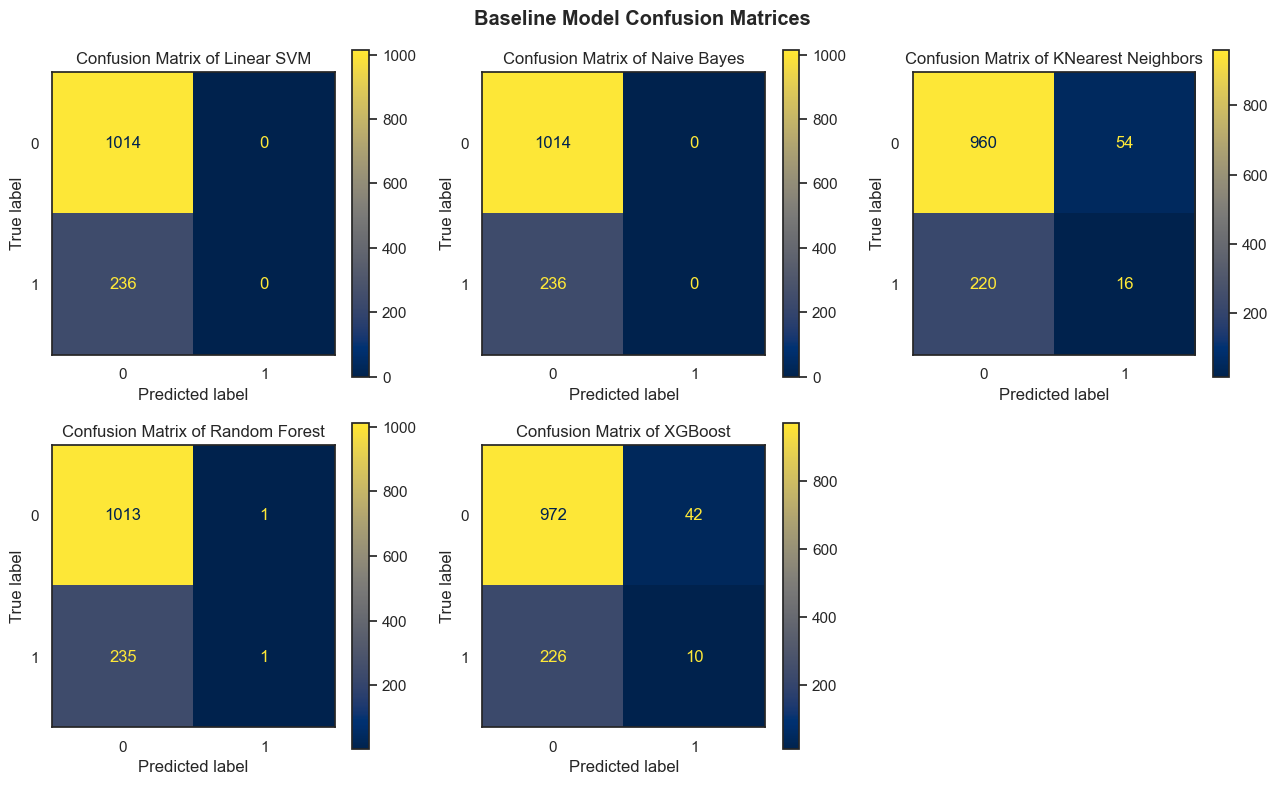

In [123]:
# Import ConfusionMatrixDisplay from sklearn metrics
from sklearn.metrics import ConfusionMatrixDisplay
import sklearn.metrics import confusion_matrix

# Set some styling
sns.set(font_scale=1)
sns.set_style('white')

# Create a dictionary of the baseline models as key and their instance as the value
baseline_models = {'Linear SVM': lin_svc, 'Naive Bayes': nb, 'KNearest Neighbors': knn, 'Random Forest': rfc, 'XGBoost': xgb}

# Create 2 by 3 plot
fig, axes = plt.subplots(nrows=2,
                         ncols=3,
                         figsize=(13,8))

# Flatten the axes for iteration
axes = axes.ravel()

# Use for loop to iterate every model, I also use enumerate so I can get the index for the axes
for i, (model, instance) in enumerate(baseline_models.items()):
    # Make predictions per model
    y_preds = instance.predict(X_test)
    cm = confusion_matrix(y_test, y_preds)

    # Plot the confusion matrix of each model
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap = 'cividis', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix of {model}')

# Remove any unused subplots
for blank in range(len(baseline_models), len(axes)):
    fig.delaxes(axes[blank])

# Add some information
fig.suptitle('Baseline Model Confusion Matrices', fontweight='bold')
plt.tight_layout()
plt.show()

<BarContainer object of 5 artists>

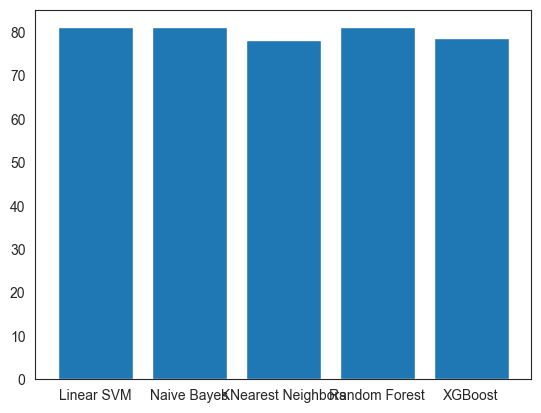

In [55]:
plt.bar(baseline_scores.keys(), baseline_scores.values())

### Check imbalance class

In [56]:
# Check the count of classes
y_train.value_counts()

default_status
0    2987
1     763
Name: count, dtype: int64

We can see that we have severely imbalance class with 80% to 20% ratio.

We can try to use over sampling techniques, one of the famous one is Synthetic Over Sampling Technique or SMOTE.

In [57]:
# Import SMOTE
from imblearn.over_sampling import SMOTE

# Instantiate smote
smote = SMOTE()

# Resample train set
X_smote, y_smote = smote.fit_resample(X_train, y_train)

# Check balance
y_smote.value_counts()

default_status
0    2987
1    2987
Name: count, dtype: int64

Now that the class were balanced, we can now try the model again with hyperparameter tuning and see if the accuracy will improve

### Hyperparameter tuning with RandomizedSearchCV

We will use RandomizedSearchCV for quick hyperparameter tuning

In [58]:
# Create new dictionary for hyperparameter scores
tuning_scores = {}

### RandomizedSearchCV Linear SVM

In [59]:
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score

# I will use 2 metrics to validate the tuning, accuracy and recall
metrics = {'Accuracy': make_scorer(accuracy_score),
           'Recall': make_scorer(recall_score)}

In [60]:
# Import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [61]:
# Set random seed
np.random.seed(42)

# Instantiate linear SVC
lin_svc = SVC()

# Create grid for hyperparameters
grid = {'C': np.arange(0.1, 2.2, 0.2),
        'kernel': ['linear'],
        'gamma': ['scale', 'auto']}

# Set up RandomizedSearchCV
rs_svc = RandomizedSearchCV(estimator=lin_svc,
                           param_distributions=grid,
                           n_iter=10,
                           cv=5,
                           verbose=2,
                           scoring=metrics,
                           refit='Recall')

# Fit the RandomizedSearchCV model to the smote set
rs_svc.fit(X_smote, y_smote)

# Predict from X_test using the best model from RandomizedSearchCV
y_preds = rs_svc.predict(X_test)

# Using the function evaluate score and put into dictionary
evaluate_model(y_test, y_preds, 'Tuned Linear SVM', tuning_scores)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.4s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.5s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.5s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.5s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.5s
[CV] END ....C=1.3000000000000003, gamma=auto, kernel=linear; total time=   0.4s
[CV] END ....C=1.3000000000000003, gamma=auto, kernel=linear; total time=   0.5s
[CV] END ....C=1.3000000000000003, gamma=auto, kernel=linear; total time=   0.8s
[CV] END ....C=1.3000000000000003, gamma=auto, kernel=linear; total time=   0.5s
[CV] END ....C=1.3000000000000003, gamma=auto, kernel=linear; total time=   0.7s
[CV] END ...C=0.9000000000000001, gamma=scale, kernel=linear; total time=   0.2s
[CV] END ...C=0.9000000000000001, gamma=scale, kernel=linear; total time=   0.4s
[CV] END ...C=0.900000000000

{'Tuned Linear SVM': 81.12}

### RandomizedSearchCV Naive Bayes

In [62]:
# Make grid for naive bayes
grid = {
    'var_smoothing': loguniform(1e-9, 1e-5)
}

# Set random seed
np.random.seed(42)

# Instantiate naive bayes
nb = GaussianNB()

# Set up RandomizedSearchCV
rs_nb = RandomizedSearchCV(estimator=nb,
                            param_distributions=grid,
                            n_iter=10,
                            cv=5,
                            verbose=2,
                            scoring=metrics,
                            refit='Recall')

# Fit the RandomizedSearchCV model to the smote set
rs_nb.fit(X_smote, y_smote)

# Predict from X_test using the best model from RandomizedSearchCV
y_preds = rs_nb.predict(X_test)

# Using the function evaluate score and put into dictionary
evaluate_model(y_test, y_preds, 'Tuned Naive Bayes', tuning_scores)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .................var_smoothing=3.14891164795686e-08; total time=   0.0s
[CV] END .................var_smoothing=3.14891164795686e-08; total time=   0.0s
[CV] END .................var_smoothing=3.14891164795686e-08; total time=   0.0s
[CV] END .................var_smoothing=3.14891164795686e-08; total time=   0.0s
[CV] END .................var_smoothing=3.14891164795686e-08; total time=   0.0s
[CV] END ................var_smoothing=6.351221010640693e-06; total time=   0.0s
[CV] END ................var_smoothing=6.351221010640693e-06; total time=   0.0s
[CV] END ................var_smoothing=6.351221010640693e-06; total time=   0.0s
[CV] END ................var_smoothing=6.351221010640693e-06; total time=   0.0s
[CV] END ................var_smoothing=6.351221010640693e-06; total time=   0.0s
[CV] END ................var_smoothing=8.471801418819974e-07; total time=   0.0s
[CV] END ................var_smoothing=8.4718014

[CV] END ................var_smoothing=8.471801418819974e-07; total time=   0.0s
[CV] END ................var_smoothing=8.471801418819974e-07; total time=   0.0s
[CV] END ................var_smoothing=8.471801418819974e-07; total time=   0.0s
[CV] END .................var_smoothing=2.48104097486781e-07; total time=   0.0s
[CV] END .................var_smoothing=2.48104097486781e-07; total time=   0.0s
[CV] END .................var_smoothing=2.48104097486781e-07; total time=   0.0s
[CV] END .................var_smoothing=2.48104097486781e-07; total time=   0.0s
[CV] END .................var_smoothing=2.48104097486781e-07; total time=   0.0s
[CV] END ................var_smoothing=4.207988669606635e-09; total time=   0.0s
[CV] END ................var_smoothing=4.207988669606635e-09; total time=   0.0s
[CV] END ................var_smoothing=4.207988669606635e-09; total time=   0.0s
[CV] END ................var_smoothing=4.207988669606635e-09; total time=   0.0s
[CV] END ................var

{'Tuned Linear SVM': 81.12, 'Tuned Naive Bayes': 66.47999999999999}

### RandomizedSearchCV KNearest Neighbors

In [63]:
# Make grid for knn
grid = {
    'n_neighbors': np.arange(1, 21),  
    'weights': ['uniform', 'distance'], 
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  
    'p': [1, 2] 
}

# Set random seed
np.random.seed(42)

# Instantiate naive bayes
knn = KNeighborsClassifier()

# Setup RandomizedSearchCV
rs_knn = RandomizedSearchCV(estimator=knn,
                            param_distributions=grid,
                            n_iter=10,
                            cv=5,
                            verbose=2,
                            scoring='accuracy')

# Fit the RandomizedSearchCV model to the smote set
rs_knn.fit(X_smote, y_smote)

# Predict from X_test using the best model from RandomizedSearchCV
y_preds = rs_knn.predict(X_test)

# Score model
evaluate_model(y_test, y_preds, 'Tuned KNN', tuning_scores)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END algorithm=kd_tree, n_neighbors=2, p=2, weights=distance; total time=   0.1s
[CV] END algorithm=kd_tree, n_neighbors=2, p=2, weights=distance; total time=   0.1s
[CV] END algorithm=kd_tree, n_neighbors=2, p=2, weights=distance; total time=   0.1s
[CV] END algorithm=kd_tree, n_neighbors=2, p=2, weights=distance; total time=   0.1s
[CV] END algorithm=kd_tree, n_neighbors=2, p=2, weights=distance; total time=   0.1s
[CV] END algorithm=kd_tree, n_neighbors=18, p=2, weights=uniform; total time=   0.2s
[CV] END algorithm=kd_tree, n_neighbors=18, p=2, weights=uniform; total time=   0.2s
[CV] END algorithm=kd_tree, n_neighbors=18, p=2, weights=uniform; total time=   0.2s
[CV] END algorithm=kd_tree, n_neighbors=18, p=2, weights=uniform; total time=   0.2s
[CV] END algorithm=kd_tree, n_neighbors=18, p=2, weights=uniform; total time=   0.2s
[CV] END algorithm=auto, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] EN

{'Tuned Linear SVM': 81.12,
 'Tuned Naive Bayes': 66.47999999999999,
 'Tuned KNN': 71.12}

In [64]:
# Make grid for Random Forest
grid = {
    'n_estimators': np.arange(100, 1501, 100),
    'max_depth': np.arange(3, 21),
    'min_samples_split': np.arange(2, 21),
    'min_samples_leaf': np.arange(1, 21),
    'max_features': [None, 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Set random seed
np.random.seed(42)

# Instantiate Random Forest classifier
rf = RandomForestClassifier()

# Setup RandomizedSearchCV
rs_rf = RandomizedSearchCV(estimator=rf,
                           param_distributions=grid,
                           n_iter=10,
                           cv=5,
                           verbose=2,
                           scoring=metrics,
                           refit='Recall')

# Fit the RandomizedSearchCV model to the smote set
rs_rf.fit(X_smote, y_smote)

# Predict from X_test using the best model from RandomizedSearchCV
y_preds = rs_rf.predict(X_test)

# Score model
evaluate_model(y_test, y_preds, 'Tuned Random Forest', tuning_scores)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=19, n_estimators=900; total time=  14.9s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=19, n_estimators=900; total time=  14.3s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=19, n_estimators=900; total time=  14.8s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=19, n_estimators=900; total time=  14.6s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=19, n_estimators=900; total time=  14.8s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=19, n_estimators=800; total time=   4.0s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=19, n_estimators=800;

{'Tuned Linear SVM': 81.12,
 'Tuned Naive Bayes': 66.47999999999999,
 'Tuned KNN': 71.12,
 'Tuned Random Forest': 76.32}

### RandomizedSearchCV XGBoost

In [65]:
# Make grid for XGBoost
grid = {
    'n_estimators': np.arange(100, 1501, 100),
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': np.arange(3, 11),
    'min_child_weight': np.arange(1, 11),
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.1, 0.5, 1, 10],
    'reg_lambda': [0, 0.1, 0.5, 1, 10]
}

# Set random seed
np.random.seed(42)

# Instantiate XGBoost classifier
 = XGBClassifier()

# Setup RandomizedSearchCV
rs_ = RandomizedSearchCV(estimator=xgb,
                            param_distributions=grid,
                            n_iter=10,
                            cv=5,
                            verbose=2,
                            scoring=metrics,
                            refit='Recall')

# Fit the RandomizedSearchCV model to the smote set
rs_.fit(X_smote, y_smote)

# Predict from X_test using the best model from RandomizedSearchCV
y_preds = rs_.predict(X_test)

# Score model
evaluate_model(y_test, y_preds, 'Tuned XGBoost', tuning_scores)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.2, max_depth=9, min_child_weight=5, n_estimators=1000, reg_alpha=10, reg_lambda=0.5, subsample=1.0; total time=   4.3s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.2, max_depth=9, min_child_weight=5, n_estimators=1000, reg_alpha=10, reg_lambda=0.5, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.2, max_depth=9, min_child_weight=5, n_estimators=1000, reg_alpha=10, reg_lambda=0.5, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.2, max_depth=9, min_child_weight=5, n_estimators=1000, reg_alpha=10, reg_lambda=0.5, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.2, max_depth=9, min_child_weight=5, n_estimators=1000, reg_alpha=10, reg_lambda=0.5, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rat

{'Tuned Linear SVM': 81.12,
 'Tuned Naive Bayes': 66.47999999999999,
 'Tuned KNN': 71.12,
 'Tuned Random Forest': 76.32,
 'Tuned XGBoost': 78.96}

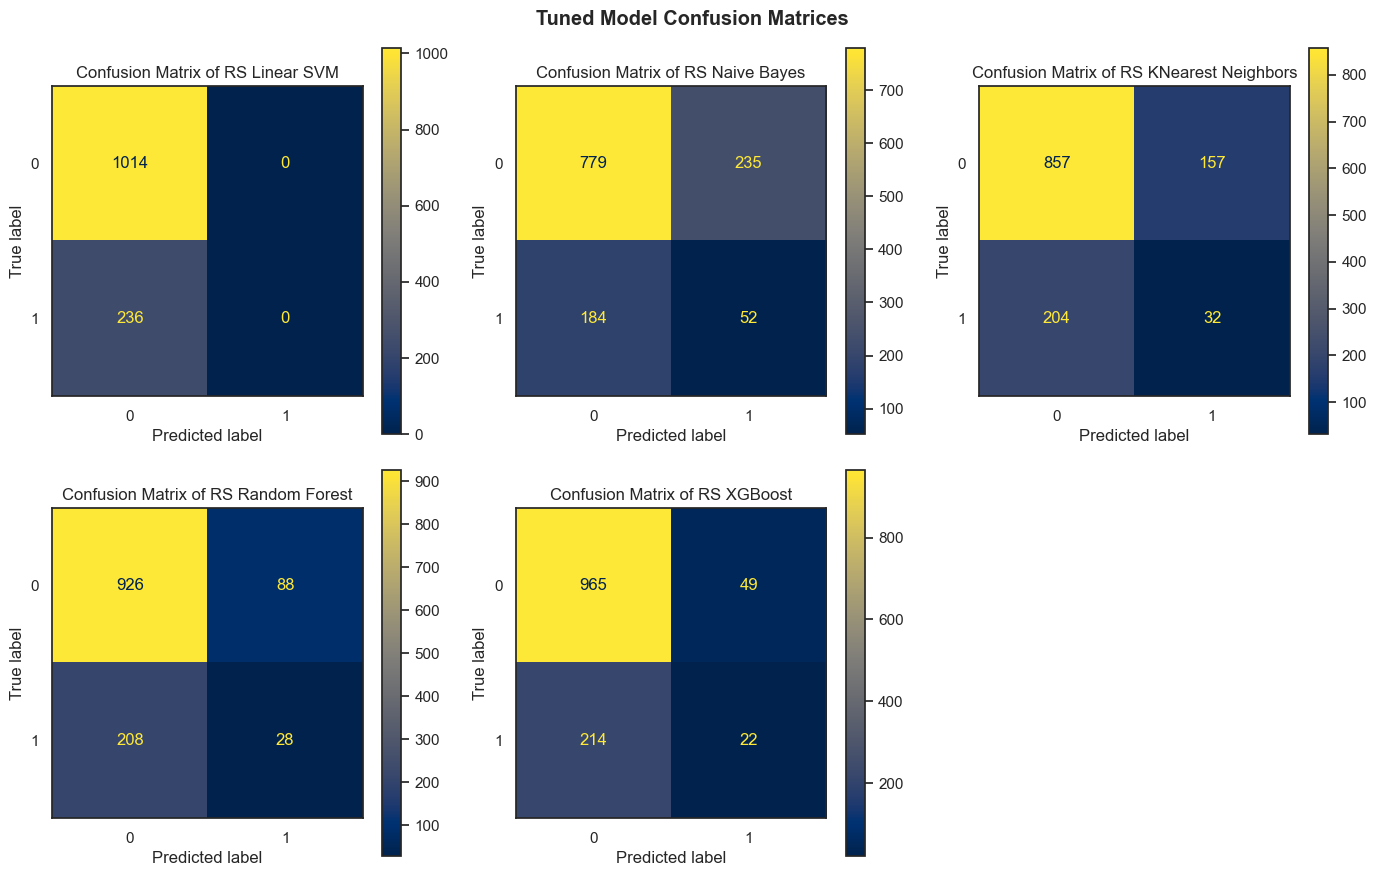

In [129]:
# Import ConfusionMatrixDisplay from sklearn metrics
from sklearn.metrics import ConfusionMatrixDisplay

# Set some styling
sns.set(font_scale=1)
sns.set_style('white')

# Create a dictionary of the baseline models as key and their instance as the value
tuned_models = {'RS Linear SVM': rs_svc, 'RS Naive Bayes': rs_nb, 'RS KNearest Neighbors': rs_knn, 'RS Random Forest': rs_rf, 'RS XGBoost': rs_xgb}

# Create 2 by 3 plot
fig, axes = plt.subplots(nrows=2,
                         ncols=3,
                         figsize=(14,9))

# Flatten the axes for iteration
axes = axes.ravel()

# Use for loop to iterate every model, I also use enumerate so I can get the index for the axes
for i, (model, instance) in enumerate(tuned_models.items()):
    # Make predictions per model
    y_preds = instance.predict(X_test)
    cm = confusion_matrix(y_test, y_preds)

    # Plot the confusion matrix of each model
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap = 'cividis', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix of {model}')

# Remove any unused subplots
for blank in range(len(baseline_models), len(axes)):
    fig.delaxes(axes[blank])

# Add some information
fig.suptitle('Tuned Model Confusion Matrices', fontweight='bold')
plt.tight_layout()
plt.show()

In [67]:
recall_score(y_test, y_preds)

0.09322033898305085

<BarContainer object of 24 artists>

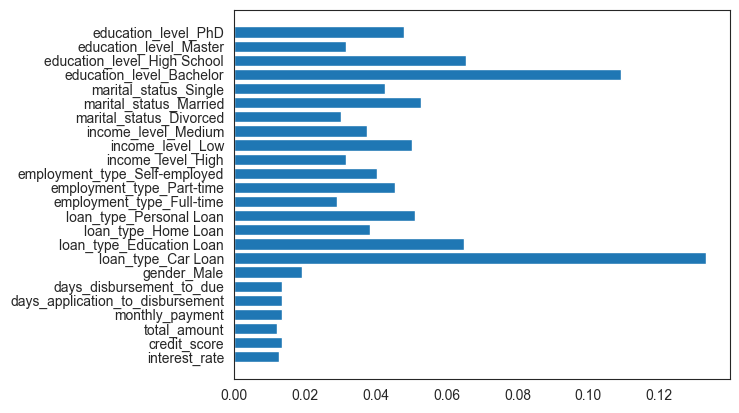

In [70]:
plt.barh(X_smote.columns.tolist(), rs_xgb.best_estimator_.feature_importances_)